In [6]:
import numpy as np
import uproot
import vector
import awkward
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
import sklearn as skl
import torch 
seed_value = 420 
from numpy.random import seed
seed(seed_value)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve

#directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

   ### Functions for plotting

In [7]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(awkward.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label, histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

In [8]:
mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

### Extracting Data

In [9]:
tree4 = uproot.open(directory + "ttt_304014_mc20a_fullsim.root")
tree4_big = uproot.open(directory + "4tops_inclusive_17july_combined.root")

events_4t = tree4["reco;1"].arrays(['jet_e_NOSYS','jet_eta','jet_partonid','jet_phi','jet_pt_NOSYS', 'jet_truthHiggsIndex', 'jet_truthTopIndex', 'jet_truthflav', 'jets_deltaR_NOSYS', 'lepton_0_charge_NOSYS', 'lepton_0_pt_GeV_NOSYS', 'lepton_0plus1_pt_GeV_NOSYS', 'lepton_1_charge_NOSYS', 'lepton_1_pt_GeV_NOSYS', 'lepton_2_charge_NOSYS', 'lepton_2_pt_GeV_NOSYS', 'lepton_3_charge_NOSYS', 'lepton_3_pt_GeV_NOSYS', 'lepton_Id', 'lepton_charge', 'lepton_e_NOSYS', 'lepton_eta', 'lepton_phi', 'lepton_pt_NOSYS', 'lepton_truthCat'])
events_3t = tree3["reco;1"].arrays(['jet_e_NOSYS','jet_eta','jet_partonid','jet_phi','jet_pt_NOSYS', 'jet_truthHiggsIndex', 'jet_truthTopIndex', 'jet_truthflav', 'jets_deltaR_NOSYS', 'lepton_0_charge_NOSYS', 'lepton_0_pt_GeV_NOSYS', 'lepton_0plus1_pt_GeV_NOSYS', 'lepton_1_charge_NOSYS', 'lepton_1_pt_GeV_NOSYS', 'lepton_2_charge_NOSYS', 'lepton_2_pt_GeV_NOSYS', 'lepton_3_charge_NOSYS', 'lepton_3_pt_GeV_NOSYS', 'lepton_Id', 'lepton_charge', 'lepton_e_NOSYS', 'lepton_eta', 'lepton_phi', 'lepton_pt_NOSYS', 'lepton_truthCat'])

jets_pt_4t = events_4t['jet_pt_NOSYS']
jets_eta_4t = events_4t['jet_eta']
jets_phi_4t = events_4t['jet_phi']
jets_e_4t = events_4t['jet_e_NOSYS']

jets_pt_3t = events_3t['jet_pt_NOSYS']
jets_eta_3t = events_3t['jet_eta']
jets_phi_3t = events_3t['jet_phi']
jets_e_3t = events_3t['jet_e_NOSYS']

jets_4t = vector.zip({'pt':jets_pt_4t,'eta':jets_eta_4t,'phi':jets_phi_4t,'energy':jets_e_4t})
jets_3t = vector.zip({'pt':jets_pt_3t,'eta':jets_eta_3t,'phi':jets_phi_3t,'energy':jets_e_3t})

leptons_pt_4t = events_4t['lepton_pt_NOSYS']
leptons_eta_4t = events_4t['lepton_eta']
leptons_phi_4t = events_4t['lepton_phi']
leptons_e_4t = events_4t['lepton_e_NOSYS']

leptons_pt_3t = events_3t['lepton_pt_NOSYS']
leptons_eta_3t = events_3t['lepton_eta']
leptons_phi_3t = events_3t['lepton_phi']
leptons_e_3t = events_3t['lepton_e_NOSYS']

leptons_4t = vector.zip({'pt':leptons_pt_4t,'eta':leptons_eta_4t,'phi':leptons_phi_4t,'energy':leptons_e_4t})
leptons_3t = vector.zip({'pt':leptons_pt_3t,'eta':leptons_eta_3t,'phi':leptons_phi_3t,'energy':leptons_e_3t})

jets_4t = jets_4t[np.argwhere([(len(a1) > 1) and (len(a2) > 1) for a1,a2 in zip(jets_4t,leptons_4t)]).flatten()]
leptons_4t = leptons_4t[np.argwhere([len(a1) > 1 and len(a2) > 1 for a1,a2 in zip(jets_4t,leptons_4t)]).flatten()]
lepton_charges_4t = events_4t['lepton_charge'][np.argwhere([len(a1) > 1 and len(a2) > 1 for a1,a2 in zip(jets_4t,leptons_4t)]).flatten()]

jets_3t = jets_3t[np.argwhere([len(a1) > 1 and len(a2) > 1 for a1,a2 in zip(jets_3t,leptons_3t)]).flatten()]
leptons_3t = leptons_3t[np.argwhere([len(a1) > 1 and len(a2) > 1 for a1,a2 in zip(jets_3t,leptons_3t)]).flatten()]
lepton_charges_3t = events_3t['lepton_charge'][np.argwhere([len(a1) > 1 and len(a2) > 1 for a1,a2 in zip(jets_3t,leptons_3t)]).flatten()]

In [10]:
print(jets_pt_4t)

[[1.63e+05, 1.27e+05, 9.73e+04, 6.84e+04], ..., [1.27e+05, ..., 5.43e+04]]


## Sorting

In [11]:
#pt
highest_pt_jet_4t = jets_4t[:,0]
highest_pt_jet_3t = jets_3t[:,0]
highest_pt_lepton_4t = leptons_4t[:,0]
highest_pt_lepton_3t = leptons_3t[:,0]

lowest_pt_jet_4t = jets_4t[:,-1]
lowest_pt_jet_3t = jets_3t[:,-1]
lowest_pt_lepton_4t = leptons_4t[:,-1]
lowest_pt_lepton_3t = leptons_3t[:,-1]

second_highest_pt_jet_4t = jets_4t[:,1]
second_highest_pt_jet_3t = jets_3t[:,1]
second_highest_pt_lepton_4t = leptons_4t[:,1]
second_highest_pt_lepton_3t = leptons_3t[:,1]

second_lowest_pt_jet_4t = jets_4t[:,-2]
second_lowest_pt_jet_3t = jets_3t[:,-2]
second_lowest_pt_lepton_4t = leptons_4t[:,-2]
second_lowest_pt_lepton_3t = leptons_3t[:,-2]

#total
highest_pt_finder_3t = np.transpose(awkward.concatenate([awkward.Array([highest_pt_jet_3t]), awkward.Array([second_highest_pt_jet_3t]), awkward.Array([highest_pt_lepton_3t]), awkward.Array([second_highest_pt_lepton_3t])], axis=0))
sorted_highest_pt_finder_3t = highest_pt_finder_3t[np.argsort(highest_pt_finder_3t.rho, axis=1)]

highest_pt_3t = vector.zip({'pt':sorted_highest_pt_finder_3t.rho[:,-1],'eta':sorted_highest_pt_finder_3t.eta[:,-1],'phi':sorted_highest_pt_finder_3t.phi[:,-1], 'energy':sorted_highest_pt_finder_3t.t[:,-1]})
second_highest_pt_3t = vector.zip({'pt':sorted_highest_pt_finder_3t.rho[:,-2],'eta':sorted_highest_pt_finder_3t.eta[:,-2],'phi':sorted_highest_pt_finder_3t.phi[:,-2], 'energy':sorted_highest_pt_finder_3t.t[:,-2]})

lowest_pt_finder_3t = np.transpose(awkward.concatenate([awkward.Array([lowest_pt_jet_3t]), awkward.Array([second_lowest_pt_jet_3t]), awkward.Array([lowest_pt_lepton_3t]), awkward.Array([second_lowest_pt_lepton_3t])], axis=0))
sorted_lowest_pt_finder_3t = lowest_pt_finder_3t[np.argsort(lowest_pt_finder_3t.rho, axis=1)]

second_lowest_pt_3t = vector.zip({'pt':sorted_lowest_pt_finder_3t.rho[:,1],'eta':sorted_lowest_pt_finder_3t.eta[:,1],'phi':sorted_lowest_pt_finder_3t.phi[:,1], 'energy':sorted_lowest_pt_finder_3t.t[:,1]})
lowest_pt_3t = vector.zip({'pt':sorted_lowest_pt_finder_3t.rho[:,0],'eta':sorted_lowest_pt_finder_3t.eta[:,0],'phi':sorted_lowest_pt_finder_3t.phi[:,0], 'energy':sorted_lowest_pt_finder_3t.t[:,0]})

highest_pt_finder_4t = np.transpose(awkward.concatenate([awkward.Array([highest_pt_jet_4t]), awkward.Array([second_highest_pt_jet_4t]), awkward.Array([highest_pt_lepton_4t]), awkward.Array([second_highest_pt_lepton_4t])], axis=0))
sorted_highest_pt_finder_4t = highest_pt_finder_4t[np.argsort(highest_pt_finder_4t.rho,axis=1)]

highest_pt_4t = vector.zip({'pt':sorted_highest_pt_finder_4t.rho[:,-1],'eta':sorted_highest_pt_finder_4t.eta[:,-1],'phi':sorted_highest_pt_finder_4t.phi[:,-1], 'energy':sorted_highest_pt_finder_4t.t[:,-1]})
second_highest_pt_4t = vector.zip({'pt':sorted_highest_pt_finder_4t.rho[:,-2],'eta':sorted_highest_pt_finder_4t.eta[:,-2],'phi':sorted_highest_pt_finder_4t.phi[:,-2], 'energy':sorted_highest_pt_finder_4t.t[:,-2]})

lowest_pt_finder_4t = np.transpose(awkward.concatenate([awkward.Array([lowest_pt_jet_4t]), awkward.Array([second_lowest_pt_jet_4t]), awkward.Array([lowest_pt_lepton_4t]), awkward.Array([second_lowest_pt_lepton_4t])], axis=0))
sorted_lowest_pt_finder_4t = lowest_pt_finder_4t[np.argsort(lowest_pt_finder_4t.rho,axis=1)]

second_lowest_pt_4t = vector.zip({'pt':sorted_lowest_pt_finder_4t.rho[:,1],'eta':sorted_lowest_pt_finder_4t.eta[:,1],'phi':sorted_lowest_pt_finder_4t.phi[:,1], 'energy':sorted_lowest_pt_finder_4t.t[:,1]})
lowest_pt_4t = vector.zip({'pt':sorted_lowest_pt_finder_4t.rho[:,0],'eta':sorted_lowest_pt_finder_4t.eta[:,0],'phi':sorted_lowest_pt_finder_4t.phi[:,0], 'energy':sorted_lowest_pt_finder_4t.t[:,0]})

#eta
eta_4t_jets = jets_4t[np.argsort(np.abs(jets_4t.eta))]
eta_3t_jets = jets_3t[np.argsort(np.abs(jets_3t.eta))]
eta_4t_leptons = leptons_4t[np.argsort(np.abs(leptons_4t.eta))]
eta_3t_leptons = leptons_3t[np.argsort(np.abs(leptons_3t.eta))]

highest_eta_jet_4t = eta_4t_jets[:,-1]
highest_eta_jet_3t = eta_3t_jets[:,-1]
highest_eta_lepton_4t = eta_4t_leptons[:,-1]
highest_eta_lepton_3t = eta_3t_leptons[:,-1]

second_highest_eta_jet_4t = eta_4t_jets[:,-2]
second_highest_eta_jet_3t = eta_3t_jets[:,-2]
second_highest_eta_lepton_4t = eta_4t_leptons[:,-2]
second_highest_eta_lepton_3t = eta_3t_leptons[:,-2]

lowest_eta_jet_4t = eta_4t_jets[:,0]
lowest_eta_jet_3t = eta_3t_jets[:,0]
lowest_eta_lepton_4t = eta_4t_leptons[:,0]
lowest_eta_lepton_3t = eta_3t_leptons[:,0]

second_lowest_eta_jet_4t = eta_4t_jets[:,1]
second_lowest_eta_jet_3t = eta_3t_jets[:,1]
second_lowest_eta_lepton_4t = eta_4t_leptons[:,1]
second_lowest_eta_lepton_3t = eta_3t_leptons[:,1]

#total
highest_eta_finder_3t = np.transpose(awkward.concatenate([awkward.Array([highest_eta_jet_3t]), awkward.Array([second_highest_eta_jet_3t]), awkward.Array([highest_eta_lepton_3t]), awkward.Array([second_highest_eta_lepton_3t])], axis=0))
sorted_highest_eta_finder_3t = highest_eta_finder_3t[np.argsort(highest_eta_finder_3t.eta,axis=1)]

highest_eta_3t = vector.zip({'pt':sorted_highest_eta_finder_3t.rho[:,-1],'eta':sorted_highest_eta_finder_3t.eta[:,-1],'phi':sorted_highest_eta_finder_3t.phi[:,-1], 'energy':sorted_highest_eta_finder_3t.t[:,-1]})
second_highest_eta_3t = vector.zip({'pt':sorted_highest_eta_finder_3t.rho[:,-2],'eta':sorted_highest_eta_finder_3t.eta[:,-2],'phi':sorted_highest_eta_finder_3t.phi[:,-2], 'energy':sorted_highest_eta_finder_3t.t[:,-2]})

lowest_eta_finder_3t = np.transpose(awkward.concatenate([awkward.Array([lowest_eta_jet_3t]), awkward.Array([second_lowest_eta_jet_3t]), awkward.Array([lowest_eta_lepton_3t]), awkward.Array([second_lowest_eta_lepton_3t])], axis=0))
sorted_lowest_eta_finder_3t = lowest_eta_finder_3t[np.argsort(lowest_eta_finder_3t.eta,axis=1)]

second_lowest_eta_3t = vector.zip({'pt':sorted_lowest_eta_finder_3t.rho[:,1],'eta':sorted_lowest_eta_finder_3t.eta[:,1],'phi':sorted_lowest_eta_finder_3t.phi[:,1], 'energy':sorted_lowest_eta_finder_3t.t[:,1]})
lowest_eta_3t = vector.zip({'pt':sorted_lowest_eta_finder_3t.rho[:,0],'eta':sorted_lowest_eta_finder_3t.eta[:,0],'phi':sorted_lowest_eta_finder_3t.phi[:,0], 'energy':sorted_lowest_eta_finder_3t.t[:,0]})

highest_eta_finder_4t = np.transpose(awkward.concatenate([awkward.Array([highest_eta_jet_4t]), awkward.Array([second_highest_eta_jet_4t]), awkward.Array([highest_eta_lepton_4t]), awkward.Array([second_highest_eta_lepton_4t])], axis=0))
sorted_highest_eta_finder_4t = highest_eta_finder_4t[np.argsort(highest_eta_finder_4t.eta,axis=1)]

highest_eta_4t = vector.zip({'pt':sorted_highest_eta_finder_4t.rho[:,-1],'eta':sorted_highest_eta_finder_4t.eta[:,-1],'phi':sorted_highest_eta_finder_4t.phi[:,-1], 'energy':sorted_highest_eta_finder_4t.t[:,-1]})
second_highest_eta_4t = vector.zip({'pt':sorted_highest_eta_finder_4t.rho[:,-2],'eta':sorted_highest_eta_finder_4t.eta[:,-2],'phi':sorted_highest_eta_finder_4t.phi[:,-2], 'energy':sorted_highest_eta_finder_4t.t[:,-2]})

lowest_eta_finder_4t = np.transpose(awkward.concatenate([awkward.Array([lowest_eta_jet_4t]), awkward.Array([second_lowest_eta_jet_4t]), awkward.Array([lowest_eta_lepton_4t]), awkward.Array([second_lowest_eta_lepton_4t])], axis=0))
sorted_lowest_eta_finder_4t = lowest_eta_finder_4t[np.argsort(lowest_eta_finder_4t.eta,axis=1)]

second_lowest_eta_4t = vector.zip({'pt':sorted_lowest_eta_finder_4t.rho[:,1],'eta':sorted_lowest_eta_finder_4t.eta[:,1],'phi':sorted_lowest_eta_finder_4t.phi[:,1], 'energy':sorted_lowest_eta_finder_4t.t[:,1]})
lowest_eta_4t = vector.zip({'pt':sorted_lowest_eta_finder_4t.rho[:,0],'eta':sorted_lowest_eta_finder_4t.eta[:,0],'phi':sorted_lowest_eta_finder_4t.phi[:,0], 'energy':sorted_lowest_eta_finder_4t.t[:,0]})

#phi
phi_4t_jets = jets_4t[np.argsort(jets_4t.phi)]
phi_3t_jets = jets_3t[np.argsort(jets_3t.phi)]
phi_4t_leptons = leptons_4t[np.argsort(leptons_4t.phi)]
phi_3t_leptons = leptons_3t[np.argsort(leptons_3t.phi)]

highest_phi_jet_4t = phi_4t_jets[:,-1]
highest_phi_jet_3t = phi_3t_jets[:,-1]
highest_phi_lepton_4t = phi_4t_leptons[:,-1]
highest_phi_lepton_3t = phi_3t_leptons[:,-1]

second_highest_phi_jet_4t = phi_4t_jets[:,-2]
second_highest_phi_jet_3t = phi_3t_jets[:,-2]
second_highest_phi_lepton_4t = phi_4t_leptons[:,-2]
second_highest_phi_lepton_3t = phi_3t_leptons[:,-2]

lowest_phi_jet_4t = phi_4t_jets[:,0]
lowest_phi_jet_3t = phi_3t_jets[:,0]
lowest_phi_lepton_4t = phi_4t_leptons[:,0]
lowest_phi_lepton_3t = phi_3t_leptons[:,0]

second_lowest_phi_jet_4t = phi_4t_jets[:,1]
second_lowest_phi_jet_3t = phi_3t_jets[:,1]
second_lowest_phi_lepton_4t = phi_4t_leptons[:,1]
second_lowest_phi_lepton_3t = phi_3t_leptons[:,1]

#total
highest_phi_finder_3t = np.transpose(awkward.concatenate([awkward.Array([highest_phi_jet_3t]), awkward.Array([second_highest_phi_jet_3t]), awkward.Array([highest_phi_lepton_3t]), awkward.Array([second_highest_phi_lepton_3t])], axis=0))
sorted_highest_phi_finder_3t = highest_phi_finder_3t[np.argsort(highest_phi_finder_3t.phi,axis=1)]

highest_phi_3t = vector.zip({'pt':sorted_highest_phi_finder_3t.rho[:,-1],'eta':sorted_highest_phi_finder_3t.eta[:,-1],'phi':sorted_highest_phi_finder_3t.phi[:,-1], 'energy':sorted_highest_phi_finder_3t.t[:,-1]})
second_highest_phi_3t = vector.zip({'pt':sorted_highest_phi_finder_3t.rho[:,-2],'eta':sorted_highest_phi_finder_3t.eta[:,-2],'phi':sorted_highest_phi_finder_3t.phi[:,-2], 'energy':sorted_highest_phi_finder_3t.t[:,-2]})

lowest_phi_finder_3t = np.transpose(awkward.concatenate([awkward.Array([lowest_phi_jet_3t]), awkward.Array([second_lowest_phi_jet_3t]), awkward.Array([lowest_phi_lepton_3t]), awkward.Array([second_lowest_phi_lepton_3t])], axis=0))
sorted_lowest_phi_finder_3t = lowest_phi_finder_3t[np.argsort(lowest_phi_finder_3t.phi,axis=1)]

second_lowest_phi_3t = vector.zip({'pt':sorted_lowest_phi_finder_3t.rho[:,1],'eta':sorted_lowest_phi_finder_3t.eta[:,1],'phi':sorted_lowest_phi_finder_3t.phi[:,1], 'energy':sorted_lowest_phi_finder_3t.t[:,1]})
lowest_phi_3t = vector.zip({'pt':sorted_lowest_phi_finder_3t.rho[:,0],'eta':sorted_lowest_phi_finder_3t.eta[:,0],'phi':sorted_lowest_phi_finder_3t.phi[:,0], 'energy':sorted_lowest_phi_finder_3t.t[:,0]})

highest_phi_finder_4t = np.transpose(awkward.concatenate([awkward.Array([highest_phi_jet_4t]), awkward.Array([second_highest_phi_jet_4t]), awkward.Array([highest_phi_lepton_4t]), awkward.Array([second_highest_phi_lepton_4t])], axis=0))
sorted_highest_phi_finder_4t = highest_phi_finder_4t[np.argsort(highest_phi_finder_4t.phi,axis=1)]

highest_phi_4t = vector.zip({'pt':sorted_highest_phi_finder_4t.rho[:,-1],'eta':sorted_highest_phi_finder_4t.eta[:,-1],'phi':sorted_highest_phi_finder_4t.phi[:,-1], 'energy':sorted_highest_phi_finder_4t.t[:,-1]})
second_highest_phi_4t = vector.zip({'pt':sorted_highest_phi_finder_4t.rho[:,-2],'eta':sorted_highest_phi_finder_4t.eta[:,-2],'phi':sorted_highest_phi_finder_4t.phi[:,-2], 'energy':sorted_highest_phi_finder_4t.t[:,-2]})

lowest_phi_finder_4t = np.transpose(awkward.concatenate([awkward.Array([lowest_phi_jet_4t]), awkward.Array([second_lowest_phi_jet_4t]), awkward.Array([lowest_phi_lepton_4t]), awkward.Array([second_lowest_phi_lepton_4t])], axis=0))
sorted_lowest_phi_finder_4t = lowest_phi_finder_4t[np.argsort(lowest_phi_finder_4t.phi,axis=1)]

second_lowest_phi_4t = vector.zip({'pt':sorted_lowest_phi_finder_4t.rho[:,1],'eta':sorted_lowest_phi_finder_4t.eta[:,1],'phi':sorted_lowest_phi_finder_4t.phi[:,1], 'energy':sorted_lowest_phi_finder_4t.t[:,1]})
lowest_phi_4t = vector.zip({'pt':sorted_lowest_phi_finder_4t.rho[:,0],'eta':sorted_lowest_phi_finder_4t.eta[:,0],'phi':sorted_lowest_phi_finder_4t.phi[:,0], 'energy':sorted_lowest_phi_finder_4t.t[:,0]})

### Calculations

In [12]:
#pt
deltaR_highest_pt_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
deltaR_lowest_pt_4t = lowest_pt_4t.deltaR(second_lowest_pt_4t)

deltaR_highest_pt_3t = highest_pt_3t.deltaR(second_highest_pt_3t)
deltaR_lowest_pt_3t = lowest_pt_3t.deltaR(second_lowest_pt_3t)

deltaphi_highest_pt_4t = np.abs(highest_pt_4t.deltaphi(second_highest_pt_4t))
deltaphi_lowest_pt_4t = np.abs(lowest_pt_4t.deltaphi(second_lowest_pt_4t))
deltaeta_highest_pt_4t = np.abs(highest_pt_4t.deltaeta(second_highest_pt_4t))
deltaeta_lowest_pt_4t = np.abs(lowest_pt_4t.deltaeta(second_lowest_pt_4t))

deltaphi_highest_pt_3t = np.abs(highest_pt_3t.deltaphi(second_highest_pt_3t))
deltaphi_lowest_pt_3t = np.abs(lowest_pt_3t.deltaphi(second_lowest_pt_3t))
deltaeta_highest_pt_3t = np.abs(highest_pt_3t.deltaeta(second_highest_pt_3t))
deltaeta_lowest_pt_3t = np.abs(lowest_pt_3t.deltaeta(second_lowest_pt_3t))

#eta
deltaR_highest_eta_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
deltaR_lowest_eta_4t = lowest_eta_4t.deltaR(second_lowest_eta_4t)

deltaR_highest_eta_3t = highest_eta_3t.deltaR(second_highest_eta_3t)
deltaR_lowest_eta_3t = lowest_eta_3t.deltaR(second_lowest_eta_3t)

deltaphi_highest_eta_4t = np.abs(highest_eta_4t.deltaphi(second_highest_eta_4t))
deltaphi_lowest_eta_4t = np.abs(lowest_eta_4t.deltaphi(second_lowest_eta_4t))
deltaeta_highest_eta_4t = np.abs(highest_eta_4t.deltaeta(second_highest_eta_4t))
deltaeta_lowest_eta_4t = np.abs(lowest_eta_4t.deltaeta(second_lowest_eta_4t))

deltaphi_highest_eta_3t = np.abs(highest_eta_3t.deltaphi(second_highest_eta_3t))
deltaphi_lowest_eta_3t = np.abs(lowest_eta_3t.deltaphi(second_lowest_eta_3t))
deltaeta_highest_eta_3t = np.abs(highest_eta_3t.deltaeta(second_highest_eta_3t))
deltaeta_lowest_eta_3t = np.abs(lowest_eta_3t.deltaeta(second_lowest_eta_3t))

#phi
deltaR_highest_phi_4t = highest_phi_4t.deltaR(second_highest_phi_4t)
deltaR_lowest_phi_4t = lowest_phi_4t.deltaR(second_lowest_phi_4t)

deltaR_highest_phi_3t = highest_phi_3t.deltaR(second_highest_phi_3t)
deltaR_lowest_phi_3t = lowest_phi_3t.deltaR(second_lowest_phi_3t)

deltaphi_highest_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
deltaphi_lowest_phi_4t = np.abs(lowest_phi_4t.deltaphi(second_lowest_phi_4t))
deltaeta_highest_phi_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
deltaeta_lowest_phi_4t = np.abs(lowest_phi_4t.deltaeta(second_lowest_phi_4t))

deltaphi_highest_phi_3t = np.abs(highest_phi_3t.deltaphi(second_highest_phi_3t))
deltaphi_lowest_phi_3t = np.abs(lowest_phi_3t.deltaphi(second_lowest_phi_3t))
deltaeta_highest_phi_3t = np.abs(highest_phi_3t.deltaeta(second_highest_phi_3t))
deltaeta_lowest_phi_3t = np.abs(lowest_phi_3t.deltaeta(second_lowest_phi_3t))


## Machine learning

### Defining function

In [13]:
def neural_network(signal_data, background_data):

    epochs = 10  # number of training epochs
    batch_size = 32  # number of samples per batch
    input_size = len(signal_data)  # The number of features
    num_classes = 2  # The number of output classes. In this case: [signal, background]
    hidden1_size = 20  # The number of nodes at the first hidden layer
    hidden2_size = 20  # The number of nodes at the second hidden layer
    learning_rate = 0.01  # The speed of convergence
    verbose = True  # flag for printing out stats at each epoch
    torch.manual_seed(seed_value)  # set random seed for PyTorch

    signal_combined = np.column_stack(signal_data)
    background_combined = np.column_stack(background_data)

    data_combined = np.concatenate([signal_combined,background_combined])
    print(data_combined)

    signal_labels = np.ones(len(signal_data[0]), dtype=int)  # Shape (14009,)
    background_labels = np.zeros(len(background_data[0]), dtype=int)  # Shape (371486,)
    #print(signal_labels)
    #print(background_labels)
    # Combine labels
    labels_combined = awkward.concatenate([signal_labels, background_labels])
    print(labels_combined)
    print(np.shape(data_combined))
    print(len(labels_combined))

    X_train, X_test, y_train, y_test = train_test_split(data_combined, labels_combined, test_size=0.33, random_state=seed_value)
    #print(y_test)
    #print(X_train)
    scaler = StandardScaler()
    scaler.fit(X_train)
    from sklearn.utils import class_weight

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #print(X_train_scaled)
    class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)
    RF_clf = RandomForestClassifier(criterion="gini", max_depth=8, n_estimators=30, random_state=seed_value, class_weight={0: class_weights[0], 1: class_weights[1]})  # initialise your random forest classifier
    RF_clf.fit(X_train_scaled, y_train)  # fit to the training data
    y_pred_RF = RF_clf.predict(X_test_scaled)  # make predictions on the test data
    print(y_pred_RF[:15])
    # See how well the classifier does
    print("Accuracy score of random forest :", accuracy_score(y_test, y_pred_RF))

    importances = RF_clf.feature_importances_
    plt.bar(range(len(importances)), importances)
    plt.show()
    X_train_tensor = torch.as_tensor(X_train_scaled, dtype=torch.float)  # make tensor from X_train_scaled
    y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)  # make tensor from y_train

    X_train_var, y_train_var = Variable(X_train_tensor), Variable(y_train_tensor)  # make variables from tensors

    X_valid_var, y_valid_var = (X_train_var[:100],y_train_var[:100],)  # get first 100 events for validation
    X_train_nn_var, y_train_nn_var = (X_train_var[100:],y_train_var[100:],)  # get remaining events for training

    train_data = Data.TensorDataset(X_train_nn_var, y_train_nn_var)  # create training dataset
    valid_data = Data.TensorDataset(X_valid_var, y_valid_var)  # create validation dataset

    train_loader = Data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,)
    valid_loader = Data.DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=True,)

    class Classifier_MLP(nn.Module):  # define Multi-Layer Perceptron
        def __init__(self, in_dim, hidden_dim1, hidden_dim2, out_dim):  # initialise
            super().__init__()  # lets you avoid referring to the base class explicitly

            self.h1 = nn.Linear(in_dim, hidden_dim1)  # hidden layer 1
            self.h2 = nn.Linear(hidden_dim1,hidden_dim2)  # hidden layer 2
            self.out = nn.Linear(hidden_dim2, out_dim)  # output layer
            self.out_dim = out_dim  # output layer dimension

        def forward(self, x):  # order of the layers

            x = F.relu(self.h1(x))  # ReLU activation for first hidden layer
            x = F.relu(self.h2(x))  # ReLU activation for second hidden layer
            x = self.out(x)  # no activation function for output layer

            return x, F.softmax(x, dim=1)  # SoftMax function
        
    NN_clf = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden1_size, hidden_dim2=hidden2_size, out_dim=num_classes)
    optimizer = torch.optim.SGD(NN_clf.parameters(), lr=learning_rate)

    _results = []  # define empty list for epoch, train_loss, valid_loss, accuracy
    for epoch in range(epochs):  # loop over the dataset multiple times

        # training loop for this epoch
        NN_clf.train()  # set the model into training mode

        train_loss = 0.0  # start training loss counter at 0
        for batch, (x_train_batch, y_train_batch) in enumerate(train_loader):  # loop over train_loader

            NN_clf.zero_grad()  # set the gradients to zero before backpropragation because PyTorch accumulates the gradients
            out, prob = NN_clf(x_train_batch)  # get output and probability on this training batch
            # Calculate loss
            loss = F.cross_entropy(out, y_train_batch)  # This should work correctly

            loss.backward()  # compute dloss/dx
            optimizer.step()  # updates the parameters

            train_loss += loss.item() * x_train_batch.size(0)  # add to counter for training loss

        train_loss /= len(train_loader.dataset)  # divide train loss by length of train_loader

        if verbose:  # if verbose flag set to True
            print("Epoch: {}, Train Loss: {:4f}".format(epoch, train_loss))

    # validation loop for this epoch:
        NN_clf.eval()  # set the model into evaluation mode
        with torch.no_grad():  # turn off the gradient calculations

            correct = 0
            valid_loss = 0  # start counters for number of correct and validation loss
            for i, (x_valid_batch, y_valid_batch) in enumerate(valid_loader):  # loop over validation loader

                out, prob = NN_clf(x_valid_batch)  # get output and probability on this validation batch
                loss = F.cross_entropy(out, y_valid_batch)  # compute loss as cross entropy

                valid_loss += loss.item() * x_valid_batch.size(0)  # add to counter for validation loss

                preds = prob.argmax(dim=1, keepdim=True)  # get predictions
                correct += (preds.eq(y_valid_batch.view_as(preds)).sum().item())  # count number of correct

            valid_loss /= len(valid_loader.dataset)  # divide validation loss by length of validation dataset
            accuracy = correct / len(valid_loader.dataset)  # calculate accuracy as number of correct divided by total

        if verbose:  # if verbose flag set to True
            print("Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(valid_loss, accuracy))

    # create output row:
        _results.append([epoch, train_loss, valid_loss, accuracy])

    results = np.array(_results)  # make array of results
    print("Finished Training")
    print("Final validation error: ", 100.0 * (1 - accuracy), "%")

    X_test_tensor = torch.as_tensor(X_test_scaled, dtype=torch.float)
    y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)

    X_test_var, y_test_var = Variable(X_test_tensor), Variable(y_test_tensor)

    out, prob = NN_clf(X_test_var)
    y_pred_NN = (prob.cpu().detach().numpy().argmax(axis=1))

    print("Accuracy score of neural network: ", accuracy_score(y_test, y_pred_NN))

    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_test, RF_clf.predict_proba(X_test)[:,1])
    print(f'AUC: {auc}')

    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(RF_clf, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    print(f'Cross-Validation AUC: {scores.mean()}')

    decisions_rf = RF_clf.predict_proba(X_test_scaled)[:, 1]
    decisions_nn = (NN_clf(X_test_var)[1][:, 1].cpu().detach().numpy())

    from sklearn.metrics import confusion_matrix
    y_pred = RF_clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print(decisions_rf)
    print(decisions_rf)

    print(classification_report(y_test, y_pred_RF, target_names=["background", "signal"]))
    print(classification_report(y_test, y_pred_NN, target_names=["background", "signal"]))
    
    fig, ax = plt.subplots(1,4, figsize=(20,8))
    histogram([decisions_rf[y_test == 0], decisions_rf[y_test == 1]], 50, ['Background Events','Signal Events'], ax[0], ratio=False, density=False)
    ax[0].set_xlabel("Threshold")  # x-axis label
    ax[0].semilogy()  # make the y-axis semi-log

    fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, decisions_rf)
    fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, decisions_nn)

    
    ax[1].plot(fpr_rf, tpr_rf, label="Random Forest")  # plot random forest ROC
    ax[1].plot(fpr_nn, tpr_nn, linestyle="dashed", label="Neural Network")  # plot neural network ROC
    ax[1].plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")  # plot diagonal line to indicate luck
    ax[1].set_xlabel("False Positive Rate")  # x-axis label
    ax[1].set_ylabel("True Positive Rate")  # y-axis label
    ax[1].grid()  # add a grid to the plot
    ax[1].legend()

    def AMS(TPR,FPR,b_r):
        AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
        return AMS

    b_reg = 0.001
    ams_rf = AMS(tpr_rf,fpr_rf,b_reg)
    ams_nn = AMS(tpr_nn,fpr_nn,b_reg)
    
    ax[2].plot(thresholds_rf, ams_rf, label="Random Forest")  # plot random forest AMS
    ax[2].plot(thresholds_nn, ams_nn, linestyle="dashed", label="Neural Network")  # plot neural network AMS
    ax[2].set_xlabel("Threshold")  # x-axis label
    ax[2].set_ylabel("AMS")  # y-axis label
    ax[2].set_title(f"AMS with $b_r$ = {b_reg:.2g}")  # add plot title
    ax[2].legend()

    def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
        decisions = [] # list to hold decisions of classifier
        for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
            if hasattr(clf, "predict_proba"): # if predict_proba function exists
                d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
                d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
            else: # predict_proba function doesn't exist
                X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
                y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
                X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
                d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
                d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
            decisions += [d1, d2] # add to list of classifier decision
    
        highest_decision = max(np.max(d) for d in decisions) # get maximum score
        bin_edges = [] # list to hold bin edges
        bin_edge = -0.1 # start counter for bin_edges
        while bin_edge < highest_decision: # up to highest score
            bin_edge += 0.1 # increment
            bin_edges.append(bin_edge)

        histogram([decisions[0],decisions[1]], bin_edges, ['Background (training data)','Signal (training data)'],ax[3],ratio=False, density = True)

        hist_background, bin_edges = np.histogram(decisions[2], bins=bin_edges, density=True )
    
        scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
        err_background = np.sqrt(hist_background * scale) / scale # error on test background

        width = 0.1 # histogram bin width
        center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
        ax[3].errorbar(x=center, y=hist_background, yerr=err_background, fmt='o',  c='blue', label='Background (test)' ) # Background (test)
    
        hist_signal, bin_edges = np.histogram(decisions[3],bins=bin_edges,density=True )
        scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
        err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
        ax[3].errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', c='orange', label='Signal (test)' )
    
        ax[3].set_xlabel(xlabel) # write x-axis label
        ax[3].set_ylabel("Arbitrary units") # write y-axis label
        ax[3].legend() # add legend
    compare_train_test(RF_clf, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest output")
    return None

### Data conversions jets

In [14]:
jets_4t_pt_flat = awkward.flatten(jets_4t.pt)
jets_4t_eta_flat = awkward.flatten(jets_4t.eta)
jets_4t_phi_flat = awkward.flatten(jets_4t.phi)
jets_3t_pt_flat = awkward.flatten(jets_3t.pt)
jets_3t_eta_flat = awkward.flatten(jets_3t.eta)
jets_3t_phi_flat = awkward.flatten(jets_3t.phi)
jets_pt_flat = np.concatenate([jets_4t_pt_flat,jets_3t_pt_flat])
jets_eta_flat = np.concatenate([jets_4t_eta_flat,jets_3t_eta_flat])
jets_phi_flat = np.concatenate([jets_4t_phi_flat,jets_3t_phi_flat])

print(jets_4t_eta_flat)
print(jets_4t_pt_flat)
print(jets_3t_eta_flat)
print(jets_3t_pt_flat)
print(jets_4t_phi_flat)
print(jets_3t_phi_flat)

print(len(jets_4t_eta_flat))
print(len(jets_3t_eta_flat))


[0.589, 0.197, 0.895, -0.497, 0.724, ..., -1.9, 0.238, 0.039, 0.0866, 0.33]
[1.63e+05, 1.27e+05, 9.73e+04, 6.84e+04, ..., 7.66e+04, 7.49e+04, 5.43e+04]
[1.23, -0.753, -0.786, -0.119, -0.838, ..., 1.41, 0.112, -2.42, 0.733, -0.511]
[1.39e+05, 1.36e+05, 6.83e+04, 4.16e+04, ..., 6.56e+04, 5.69e+04, 3.76e+04]
[-0.374, 2.5, 2.4, 1.85, 0.227, -2.05, ..., -2.45, 1.15, -2.61, 1.99, 2.77]
[-0.96, 1.42, -0.837, 1.85, 2.81, 3.09, ..., 1.11, -1.65, -2.62, 1.86, 2.81]
14009
371486


In [15]:
leptons_4t_pt_flat = awkward.flatten(leptons_4t.pt)
leptons_4t_eta_flat = awkward.flatten(leptons_4t.eta)
leptons_4t_phi_flat = awkward.flatten(leptons_4t.phi)
leptons_3t_pt_flat = awkward.flatten(leptons_3t.pt)
leptons_3t_eta_flat = awkward.flatten(leptons_3t.eta)
leptons_3t_phi_flat = awkward.flatten(leptons_3t.phi)
leptons_pt_flat = np.concatenate([leptons_4t_pt_flat,leptons_3t_pt_flat])
leptons_eta_flat = np.concatenate([leptons_4t_eta_flat,leptons_3t_eta_flat])
leptons_phi_flat = np.concatenate([leptons_4t_phi_flat,leptons_3t_phi_flat])

print(leptons_4t_eta_flat)
print(leptons_4t_pt_flat)
print(leptons_3t_eta_flat)
print(leptons_3t_pt_flat)
print(leptons_4t_phi_flat)
print(leptons_3t_phi_flat)

print(len(leptons_4t_eta_flat))
print(len(leptons_3t_eta_flat))

[0.695, 1.2, 1.34, -1.46, 1.7, -0.0966, ..., 0.909, 2.27, 0.391, -1.03, 1.49]
[8.91e+04, 5.18e+04, 3.76e+04, 9.11e+04, ..., 2.42e+04, 2e+05, 7.3e+04]
[-0.0871, 0.618, 0.626, -1.25, 0.353, ..., -2.03, -0.817, 0.354, 1.89, 0.0581]
[7.19e+04, 4.76e+04, 9.8e+04, 7.41e+04, ..., 8.88e+04, 8.21e+04, 6.61e+04]
[-2.87, 0.0599, -2.23, 1.03, -2.33, ..., 2.11, 1.36, -0.97, -0.981, -0.0255]
[2.1, -1.31, -1.88, 0.377, 1.77, -2, ..., 2.12, -2.84, 0.47, -1.83, 0.274]
5057
113119


[[-0.374], [2.5], [2.4], [1.85], [0.227], ..., [-1.65], [-2.62], [1.86], [2.81]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[385495, 1]
385495
[0 0 0 0 1 0 0 1 1 0 1 1 0 0 0]
Accuracy score of random forest : 0.6850268052258399


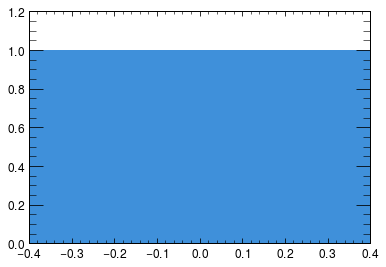

Epoch: 0, Train Loss: 0.159323
Validation Loss: 0.299431, Validation Accuracy: 0.920000
Epoch: 1, Train Loss: 0.155442
Validation Loss: 0.304800, Validation Accuracy: 0.920000
Epoch: 2, Train Loss: 0.155396
Validation Loss: 0.297592, Validation Accuracy: 0.920000
Epoch: 3, Train Loss: 0.155414
Validation Loss: 0.300770, Validation Accuracy: 0.920000
Epoch: 4, Train Loss: 0.155387
Validation Loss: 0.295894, Validation Accuracy: 0.920000
Epoch: 5, Train Loss: 0.155380
Validation Loss: 0.297164, Validation Accuracy: 0.920000
Epoch: 6, Train Loss: 0.155404
Validation Loss: 0.302138, Validation Accuracy: 0.920000
Epoch: 7, Train Loss: 0.155386
Validation Loss: 0.304274, Validation Accuracy: 0.920000
Epoch: 8, Train Loss: 0.155388
Validation Loss: 0.294594, Validation Accuracy: 0.920000
Epoch: 9, Train Loss: 0.155365
Validation Loss: 0.310042, Validation Accuracy: 0.920000
Finished Training
Final validation error:  7.9999999999999964 %
Accuracy score of neural network:  0.9631880138978415
AU

c:\Users\matis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

  background       0.96      1.00      0.98    122531
      signal       0.00      0.00      0.00      4683

    accuracy                           0.96    127214
   macro avg       0.48      0.50      0.49    127214
weighted avg       0.93      0.96      0.95    127214



ValueError: zero-size array to reduction operation minimum which has no identity

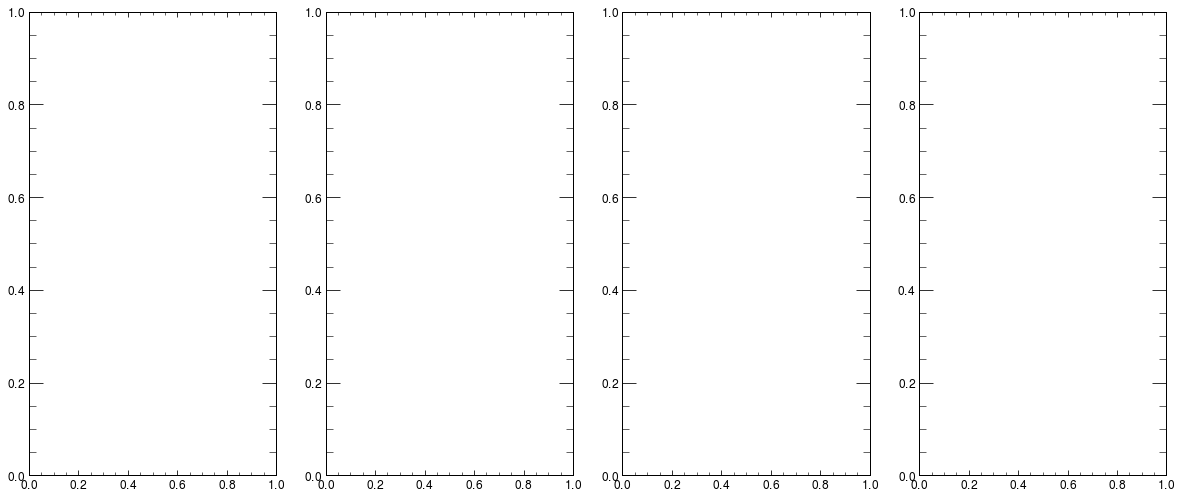

In [16]:
neural_network([jets_4t_phi_flat],[jets_3t_phi_flat])

In [176]:
#X = np.([jets_4t_pt_flat,jets_4t_eta_flat],[jets_3t_pt_flat,jets_3t_eta_flat])
#X = np.column_stack((jets_pt_flat,jets_eta_flat))
X= np.column_stack([jets_phi_flat[:len(leptons_pt_flat)],jets_eta_flat[:len(leptons_pt_flat)],jets_pt_flat[:len(leptons_pt_flat)],leptons_eta_flat,leptons_phi_flat,leptons_pt_flat])

y_4t_pt = np.ones(len(jets_4t_pt_flat))
y_3t_pt = np.zeros(len(jets_3t_pt_flat))
y_4t_eta = np.ones(len(jets_4t_eta_flat))
y_3t_eta = np.zeros(len(jets_3t_eta_flat))
y_4t_phi = np.ones(len(jets_4t_phi_flat))
y_3t_phi = np.zeros(len(jets_3t_phi_flat))


y_pt = np.concatenate([y_4t_pt,y_3t_pt])
y_eta = np.concatenate([y_4t_eta,y_3t_eta])
y_phi = np.concatenate([y_4t_phi,y_3t_phi])
y =y_pt[:len(leptons_pt_flat)]

print(X)
print(y)
print(np.shape(X))
print(len(y))

[[-0.374, 0.589, 1.63e+05, 0.695, -2.87, 8.91e+04], ..., [1.62, ..., 6.61e+04]]
[1. 1. 1. ... 0. 0. 0.]
[118176, 6]
118176


### Data reshaping

In [189]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=123)

# Resample using SMOTE
X_balanced, y_balanced = smote.fit_resample(X, y)


In [191]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.33, random_state=seed_value)
print(X_train[:10])
print(X_test[:10])
print(y_train[:10])
print(y_test[:10])

[[-1.5511098e+00  5.6561112e-01  4.9470383e+04  4.6727440e-01
  -9.4895381e-01  2.8700832e+04]
 [-8.7130141e-01  4.4930071e-02  2.2405824e+04 -9.3286961e-01
  -2.4753416e+00  4.1782078e+04]
 [ 1.1910807e+00 -8.9987427e-01  1.7542817e+05 -8.5646296e-01
   1.3786817e+00  4.9074867e+04]
 [-1.1307782e+00 -1.6524233e-01  5.8153207e+04 -2.0231742e-01
   8.2328767e-01  3.4125488e+04]
 [-5.0529152e-01  9.2102849e-01  4.9385270e+04 -1.1219871e+00
   2.6492734e+00  8.4592062e+04]
 [ 7.7767920e-01  4.6930507e-01  1.5767383e+05  5.0790608e-01
   6.3479128e-03  1.3998855e+05]
 [-4.2974362e-01  1.4109282e-02  1.7669969e+04 -4.8411196e-01
   1.2662101e+00  9.2400859e+04]
 [ 2.0394578e+00  8.5771239e-01  5.3352258e+04 -9.0908945e-02
   8.3457047e-01  9.5603242e+04]
 [-5.5974412e-01 -6.3063025e-01  3.5319105e+04  7.5641066e-01
  -9.1294122e-01  5.6854852e+04]
 [-7.0971513e-01  1.4517528e+00  5.7183586e+04  1.3308271e+00
   2.5391753e+00  1.6646491e+05]]
[[-3.0254865e-01 -1.1135900e+00  9.9582039e+04 -1

In [192]:
print(np.shape(X_train))

(139583, 6)


In [193]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)
print(X_train_scaled[10:])
print(X_test_scaled[10:])

[[ 0.04465202  0.96600336  2.6455934   1.0285149   0.00809305 -0.7226134 ]
 [-0.9230225  -0.66157293 -0.42403993 -0.45032966  0.35523236  0.39333636]
 [-0.7021777   1.8390675  -0.7675392   1.4270549  -0.88358825 -0.8534341 ]
 ...
 [ 0.62146825 -1.507364    0.01910157 -0.68432003  0.2932599  -0.22411072]
 [ 1.28008    -0.07407799 -0.6653655  -1.566377    1.5713702   0.49227756]
 [ 0.60902995  0.58186257 -0.7868159   0.21191685  0.77475315 -0.6994836 ]]
[[-1.0254626   2.037885   -0.60305977 -0.5109082   1.3173807  -0.21099645]
 [-0.45318717 -0.09028576 -0.14472364  0.08887894  0.7425338  -0.6511848 ]
 [ 0.74155444 -1.084152   -0.4463066  -0.54785955  0.33394003  3.378538  ]
 ...
 [-0.8739911   0.43643466 -0.64683604 -0.4689203   1.594814    0.21270293]
 [ 1.2431511   0.04255202 -0.62776893 -0.99029243 -1.7620784   1.4723763 ]
 [-0.26198965  0.501522   -0.52451664  0.5049143  -0.11475821  3.4691675 ]]


In [194]:
RF_clf = RandomForestClassifier(criterion="gini", max_depth=20, n_estimators=30, random_state=seed_value)  # initialise your random forest classifier
RF_clf.fit(X_train_scaled, y_train)  # fit to the training data
y_pred_RF = RF_clf.predict(X_test_scaled)  # make predictions on the test data
print(np.where(y_pred_RF==1))
print(len(np.where(y_pred_RF==1)))
# See how well the classifier does
print(accuracy_score(y_test, y_pred_RF))

(array([    0,     1,     2, ..., 68743, 68744, 68750], dtype=int64),)
1
0.6707975156724993


In [195]:
epochs = 10  # number of training epochs
batch_size = 64  # number of samples per batch
input_size = 6  # The number of features
num_classes = 2  # The number of output classes. In this case: [signal, background]
hidden_size = 64
hidden_size1 = 100  # The number of nodes at the first hidden layer
hidden_size2 = 100  # The number of nodes at the second hidden layer
dropout_rate = 0.5
learning_rate = 0.01  # The speed of convergence
verbose = True  # flag for printing out stats at each epoch
torch.manual_seed(seed_value)  # set random seed for PyTorch

In [196]:
X_train_tensor = torch.as_tensor(X_train_scaled, dtype=torch.float)  # make tensor from X_train_scaled
print(X_train_tensor)
y_train_tensor = torch.as_tensor(y_train, dtype=torch.long)  # make tensor from y_train

X_train_var, y_train_var = Variable(X_train_tensor), Variable(y_train_tensor)  # make variables from tensors
print(X_train_var)
print(y_train_var)
X_valid_var, y_valid_var = (X_train_var[:100],y_train_var[:100],)  # get first 100 events for validation
X_train_nn_var, y_train_nn_var = (X_train_var[100:],y_train_var[100:],)  # get remaining events for training

train_data = Data.TensorDataset(X_train_nn_var, y_train_nn_var)  # create training dataset
valid_data = Data.TensorDataset(X_valid_var, y_valid_var)  # create validation dataset

train_loader = Data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,)
valid_loader = Data.DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=True,)

tensor([[-0.9302,  0.5076, -0.4705,  0.4352, -0.5705, -0.8182],
        [-0.5258,  0.0310, -0.7481, -0.9027, -1.4806, -0.6196],
        [ 0.7010, -0.8337,  0.8213, -0.8297,  0.8175, -0.5089],
        ...,
        [ 0.6215, -1.5074,  0.0191, -0.6843,  0.2933, -0.2241],
        [ 1.2801, -0.0741, -0.6654, -1.5664,  1.5714,  0.4923],
        [ 0.6090,  0.5819, -0.7868,  0.2119,  0.7748, -0.6995]])
tensor([[-0.9302,  0.5076, -0.4705,  0.4352, -0.5705, -0.8182],
        [-0.5258,  0.0310, -0.7481, -0.9027, -1.4806, -0.6196],
        [ 0.7010, -0.8337,  0.8213, -0.8297,  0.8175, -0.5089],
        ...,
        [ 0.6215, -1.5074,  0.0191, -0.6843,  0.2933, -0.2241],
        [ 1.2801, -0.0741, -0.6654, -1.5664,  1.5714,  0.4923],
        [ 0.6090,  0.5819, -0.7868,  0.2119,  0.7748, -0.6995]])
tensor([0, 1, 1,  ..., 1, 1, 1])


In [197]:
class Classifier_MLP(nn.Module):  # define Multi-Layer Perceptron
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, dropout_rate, out_dim):  # initialise
        super().__init__()  # lets you avoid referring to the base class explicitly

        self.h1 = nn.Linear(in_dim, hidden_dim1)  # hidden layer 1
        self.h2 = nn.Linear(hidden_dim1,hidden_dim2)  # hidden layer 2
        self.h3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(hidden_dim2, out_dim)  # output layer
        self.out_dim = out_dim  # output layer dimension

    def forward(self, x):  # order of the layers

        x = F.relu(self.h1(x))  # ReLU activation for first hidden layer
        x = F.relu(self.h2(x))  # ReLU activation for second hidden layer
        x = F.relu(self.h3(x))  # ReLu activation for third hidden layer
        x = self.out(x)  # no activation function for output layer

        return x, F.softmax(x, dim=1)  # SoftMax function

In [198]:
NN_clf = Classifier_MLP(in_dim=input_size, hidden_dim1=hidden_size1, hidden_dim2=hidden_size2, dropout_rate=dropout_rate, out_dim=num_classes)
optimizer = torch.optim.Adam(NN_clf.parameters(), lr=learning_rate)

In [199]:
_results = []  # define empty list for epoch, train_loss, valid_loss, accuracy
for epoch in range(epochs):  # loop over the dataset multiple times

    # training loop for this epoch
    NN_clf.train()  # set the model into training mode

    train_loss = 0.0  # start training loss counter at 0
    for batch, (x_train_batch, y_train_batch) in enumerate(
        train_loader
    ):  # loop over train_loader

        NN_clf.zero_grad()  # set the gradients to zero before backpropragation because PyTorch accumulates the gradients
        out, prob = NN_clf(
            x_train_batch
        )  # get output and probability on this training batch
        loss = F.cross_entropy(out, y_train_batch)  # calculate loss as cross entropy

        loss.backward()  # compute dloss/dx
        optimizer.step()  # updates the parameters

        train_loss += loss.item() * x_train_batch.size(
            0
        )  # add to counter for training loss

    train_loss /= len(
        train_loader.dataset
    )  # divide train loss by length of train_loader

    if verbose:  # if verbose flag set to True
        print("Epoch: {}, Train Loss: {:4f}".format(epoch, train_loss))

    # validation loop for this epoch:
    NN_clf.eval()  # set the model into evaluation mode
    with torch.no_grad():  # turn off the gradient calculations

        correct = 0
        valid_loss = 0  # start counters for number of correct and validation loss
        for i, (x_valid_batch, y_valid_batch) in enumerate(
            valid_loader
        ):  # loop over validation loader

            out, prob = NN_clf(
                x_valid_batch
            )  # get output and probability on this validation batch
            loss = F.cross_entropy(out, y_valid_batch)  # compute loss as cross entropy

            valid_loss += loss.item() * x_valid_batch.size(
                0
            )  # add to counter for validation loss

            preds = prob.argmax(dim=1, keepdim=True)  # get predictions
            correct += (
                preds.eq(y_valid_batch.view_as(preds)).sum().item()
            )  # count number of correct

        valid_loss /= len(
            valid_loader.dataset
        )  # divide validation loss by length of validation dataset
        accuracy = correct / len(
            valid_loader.dataset
        )  # calculate accuracy as number of correct divided by total

    if verbose:  # if verbose flag set to True
        print(
            "Validation Loss: {:4f}, Validation Accuracy: {:4f}".format(
                valid_loss, accuracy
            )
        )

    # create output row:
    _results.append([epoch, train_loss, valid_loss, accuracy])

results = np.array(_results)  # make array of results
print("Finished Training")
print("Final validation error: ", 100.0 * (1 - accuracy), "%")

Epoch: 0, Train Loss: 0.666311
Validation Loss: 0.690466, Validation Accuracy: 0.580000
Epoch: 1, Train Loss: 0.661269
Validation Loss: 0.693542, Validation Accuracy: 0.600000
Epoch: 2, Train Loss: 0.660343
Validation Loss: 0.686746, Validation Accuracy: 0.610000
Epoch: 3, Train Loss: 0.659097
Validation Loss: 0.681756, Validation Accuracy: 0.540000
Epoch: 4, Train Loss: 0.658593
Validation Loss: 0.690267, Validation Accuracy: 0.560000
Epoch: 5, Train Loss: 0.658602
Validation Loss: 0.667685, Validation Accuracy: 0.630000
Epoch: 6, Train Loss: 0.658358
Validation Loss: 0.674436, Validation Accuracy: 0.620000
Epoch: 7, Train Loss: 0.658747
Validation Loss: 0.660527, Validation Accuracy: 0.600000
Epoch: 8, Train Loss: 0.658588
Validation Loss: 0.669995, Validation Accuracy: 0.600000
Epoch: 9, Train Loss: 0.657802
Validation Loss: 0.686986, Validation Accuracy: 0.630000
Finished Training
Final validation error:  37.0 %


In [200]:
print(X_test_scaled)
X_test_tensor = torch.as_tensor(X_test_scaled, dtype=torch.float)
y_test_tensor = torch.as_tensor(y_test, dtype=torch.long)

X_test_var, y_test_var = Variable(X_test_tensor), Variable(y_test_tensor)
print(X_test_var)
print(y_test_var)
out, prob = NN_clf(X_test_var)
y_pred_NN = (prob.cpu().detach().numpy().argmax(axis=1))
print(np.where(y_pred_NN==1))
print(y_pred_NN)

[[-0.18744941 -1.0292845   0.04344853 -1.1797875   1.0436279  -0.61486065]
 [ 1.3080057   0.9579375  -0.2711437   0.436988   -0.35137662 -0.15744862]
 [-0.80214566 -1.6950595   0.58362174  0.77195853 -0.9779684   0.18085486]
 ...
 [-0.8739911   0.43643466 -0.64683604 -0.4689203   1.594814    0.21270293]
 [ 1.2431511   0.04255202 -0.62776893 -0.99029243 -1.7620784   1.4723763 ]
 [-0.26198965  0.501522   -0.52451664  0.5049143  -0.11475821  3.4691675 ]]
tensor([[-0.1874, -1.0293,  0.0434, -1.1798,  1.0436, -0.6149],
        [ 1.3080,  0.9579, -0.2711,  0.4370, -0.3514, -0.1574],
        [-0.8021, -1.6951,  0.5836,  0.7720, -0.9780,  0.1809],
        ...,
        [-0.8740,  0.4364, -0.6468, -0.4689,  1.5948,  0.2127],
        [ 1.2432,  0.0426, -0.6278, -0.9903, -1.7621,  1.4724],
        [-0.2620,  0.5015, -0.5245,  0.5049, -0.1148,  3.4692]])
tensor([1, 0, 1,  ..., 0, 0, 1])
(array([    0,     1,     4, ..., 68743, 68744, 68750], dtype=int64),)
[1 1 0 ... 0 0 1]


In [201]:
print(accuracy_score(y_test, y_pred_NN))

0.624834547861122


In [202]:
print(classification_report(y_test, y_pred_RF, target_names=["background", "signal"]))
print(classification_report(y_test, y_pred_NN, target_names=["background", "signal"]))

              precision    recall  f1-score   support

  background       0.71      0.57      0.63     34162
      signal       0.64      0.77      0.70     34589

    accuracy                           0.67     68751
   macro avg       0.68      0.67      0.67     68751
weighted avg       0.68      0.67      0.67     68751

              precision    recall  f1-score   support

  background       0.63      0.60      0.61     34162
      signal       0.62      0.65      0.64     34589

    accuracy                           0.62     68751
   macro avg       0.63      0.62      0.62     68751
weighted avg       0.63      0.62      0.62     68751



In [203]:
decisions_rf = RF_clf.predict_proba(X_test_scaled)[:, 1]
decisions_nn = (NN_clf(X_test_var)[1][:, 1].cpu().detach().numpy())
print(decisions_rf[y_test==0])
print(decisions_rf[y_test==1])
print(decisions_nn[y_test==0])
print(decisions_nn[y_test==1])

[0.59895699 0.34974465 0.6683109  ... 0.3785112  0.37875278 0.31744236]
[0.59280292 0.60559145 0.66286576 ... 0.66405487 0.65909848 0.70751171]
[0.5337312  0.37609148 0.6595422  ... 0.3907213  0.44999495 0.3796219 ]
[0.6595422  0.48582324 0.5082846  ... 0.6595422  0.6595422  0.6503415 ]


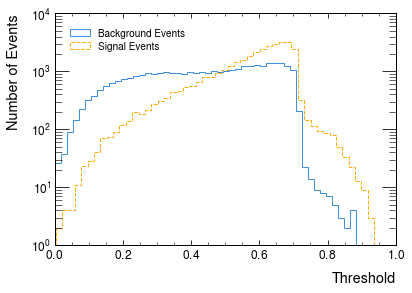

In [204]:
plt.hist(decisions_rf[y_test == 0], histtype="step", bins=50, label="Background Events")  # plot background
plt.hist(decisions_rf[y_test == 1],histtype="step",bins=50,linestyle="dashed",label="Signal Events",)  # plot signal
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("Number of Events")  # y-axis label
plt.semilogy()  # make the y-axis semi-log
plt.legend()  # draw the legend

In [205]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, decisions_rf)
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, decisions_nn)

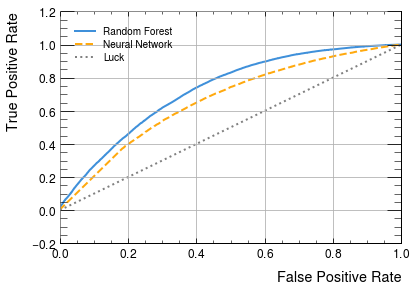

In [206]:
plt.plot(fpr_rf, tpr_rf, label="Random Forest")  # plot random forest ROC
plt.plot(fpr_nn, tpr_nn, linestyle="dashed", label="Neural Network")  # plot neural network ROC
plt.plot([0, 1], [0, 1], linestyle="dotted", color="grey", label="Luck")  # plot diagonal line to indicate luck
plt.xlabel("False Positive Rate")  # x-axis label
plt.ylabel("True Positive Rate")  # y-axis label
plt.grid()  # add a grid to the plot
plt.legend()

In [207]:
def AMS(TPR,FPR,b_r):
    AMS = np.sqrt(2*(TPR+FPR+b_r)*np.log(1+TPR/(FPR+b_r))-TPR)
    return AMS

In [208]:
b_reg = 0.001
ams_rf = AMS(tpr_rf,fpr_rf,b_reg)
ams_nn = AMS(tpr_nn,fpr_nn,b_reg)

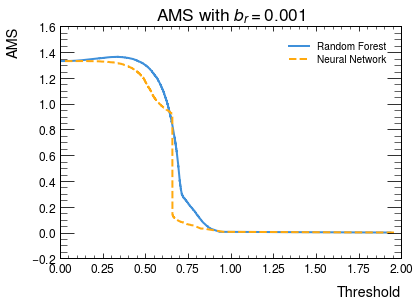

In [209]:
plt.plot(thresholds_rf, ams_rf, label="Random Forest")  # plot random forest AMS
plt.plot(thresholds_nn, ams_nn, linestyle="dashed", label="Neural Network")  # plot neural network AMS
plt.xlabel("Threshold")  # x-axis label
plt.ylabel("AMS")  # y-axis label
plt.title("AMS with $b_r=0.001$")  # add plot title
plt.legend()

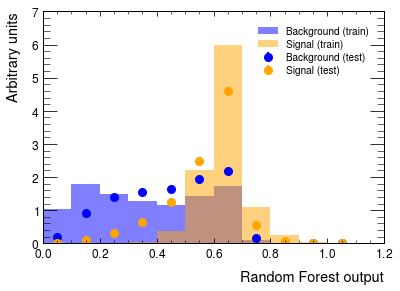

In [210]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
            d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision
    
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)
    
    plt.hist(decisions[0], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # background in train set
             bins=bin_edges, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bin_edges, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='blue', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bin_edges, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                 c='orange', label='Signal (test)' ) # Signal (test)
    
    plt.xlabel(xlabel) # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend
compare_train_test(RF_clf, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest output")

## Plots
### Pt

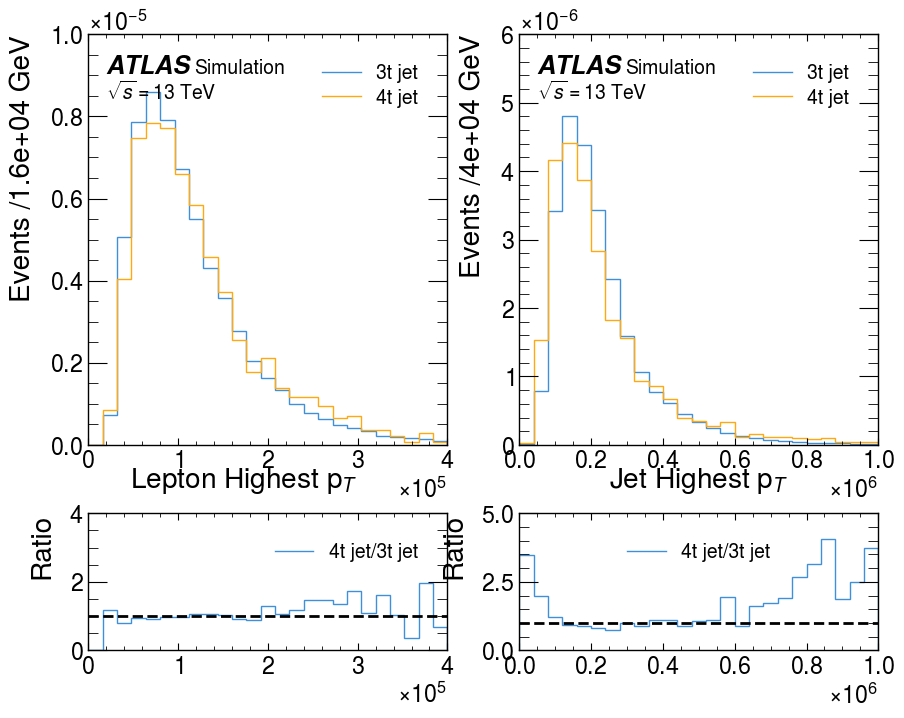

In [311]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_lepton_3t.pt, highest_pt_lepton_4t.pt], 25, ['3t jet','4t jet'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,0.4E6))
histogram([highest_pt_jet_3t.pt, highest_pt_jet_4t.pt], 25, ['3t jet','4t jet'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,1E6))
ax[0,0].set_xlabel(r'Lepton Highest p$_T$')
ax[0,0].xaxis.set_label_coords(0.75, -0.05) 
ax[0,1].set_xlabel(r'Jet Highest p$_T$')
ax[0,1].xaxis.set_label_coords(0.75, -0.05) 
plt.subplots_adjust(hspace=0.25)
plt.show()

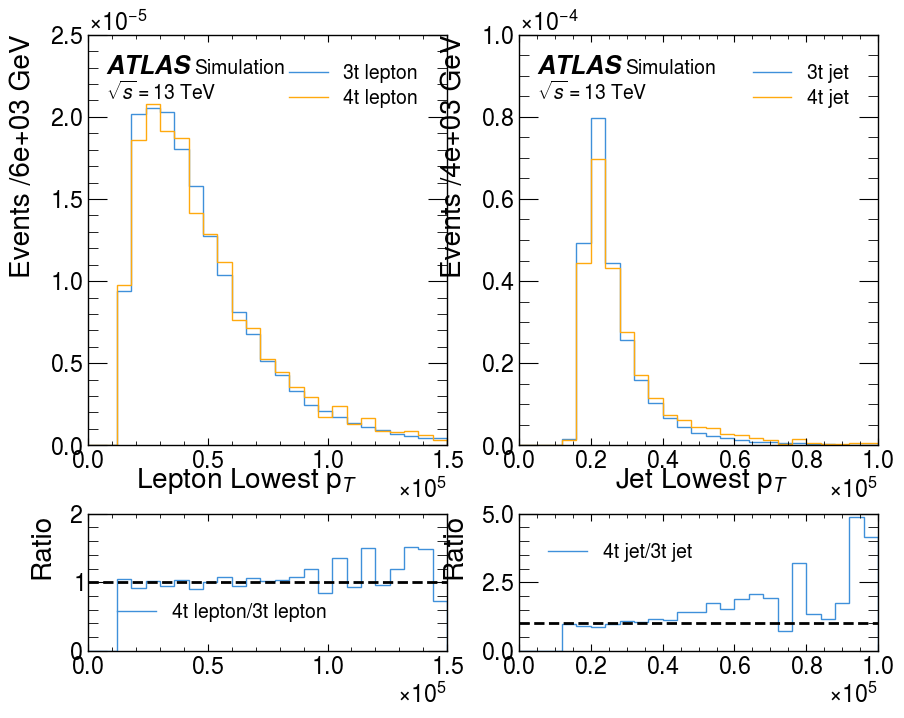

In [216]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_pt_lepton_3t.pt, lowest_pt_lepton_4t.pt], 25, ['3t lepton','4t lepton'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,1.5E5))
histogram([lowest_pt_jet_3t.pt, lowest_pt_jet_4t.pt], 25, ['3t jet','4t jet'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,1E5))
ax[0,0].set_xlabel(r'Lepton Lowest p$_T$')
ax[0,0].xaxis.set_label_coords(0.75, -0.05) 
ax[0,1].set_xlabel(r'Jet Lowest p$_T$')
ax[0,1].xaxis.set_label_coords(0.75, -0.05) 
plt.subplots_adjust(hspace=0.25)
plt.show()

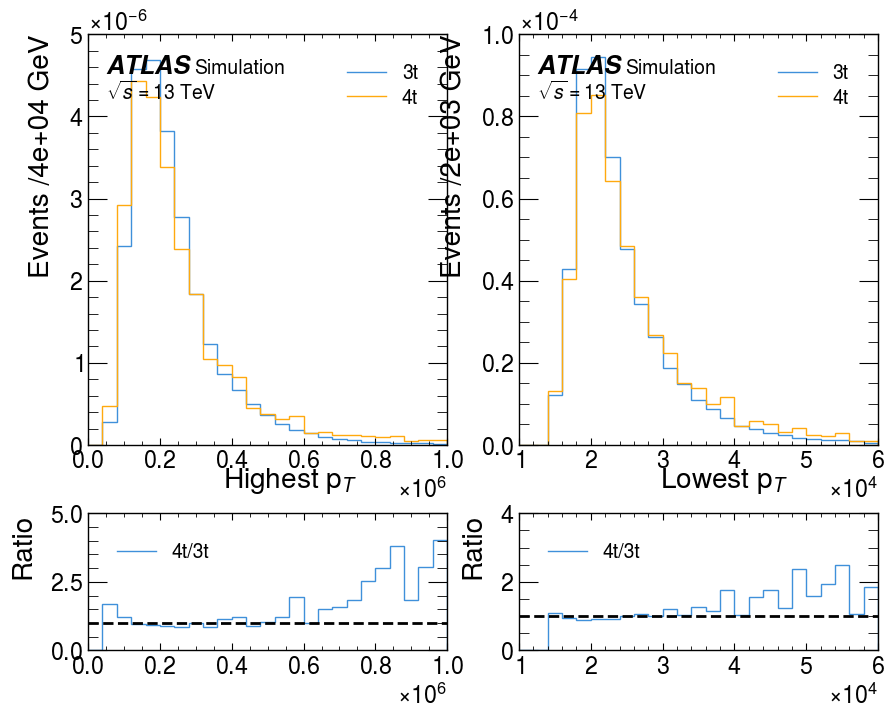

In [217]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_3t.pt, highest_pt_4t.pt], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,1E6))
histogram([lowest_pt_3t.pt, lowest_pt_4t.pt], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(1E4,6E4))
ax[0,0].set_xlabel(r'Highest p$_T$')
ax[0,0].xaxis.set_label_coords(0.75, -0.05) 
ax[0,1].set_xlabel(r'Lowest p$_T$')
ax[0,1].xaxis.set_label_coords(0.75, -0.05) 
plt.subplots_adjust(hspace=0.25)
plt.show()

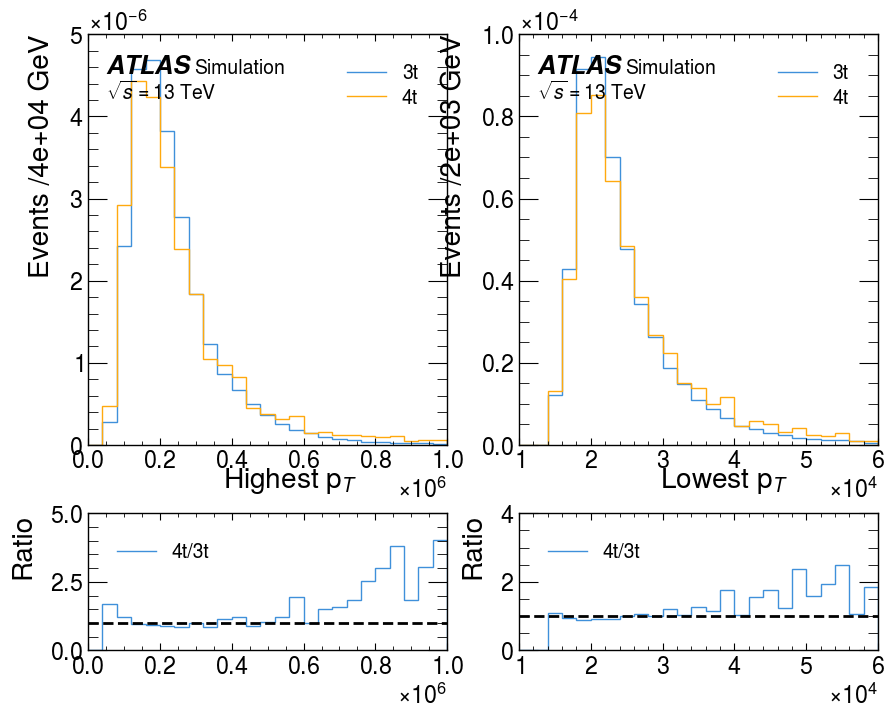

In [218]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_3t.pt, highest_pt_4t.pt], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,1E6))
histogram([lowest_pt_3t.pt, lowest_pt_4t.pt], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(1E4,6E4))
ax[0,0].set_xlabel(r'Highest p$_T$')
ax[0,0].xaxis.set_label_coords(0.75, -0.05) 
ax[0,1].set_xlabel(r'Lowest p$_T$')
ax[0,1].xaxis.set_label_coords(0.75, -0.05) 
plt.subplots_adjust(hspace=0.25)
plt.show()

### 2. $|\eta|$

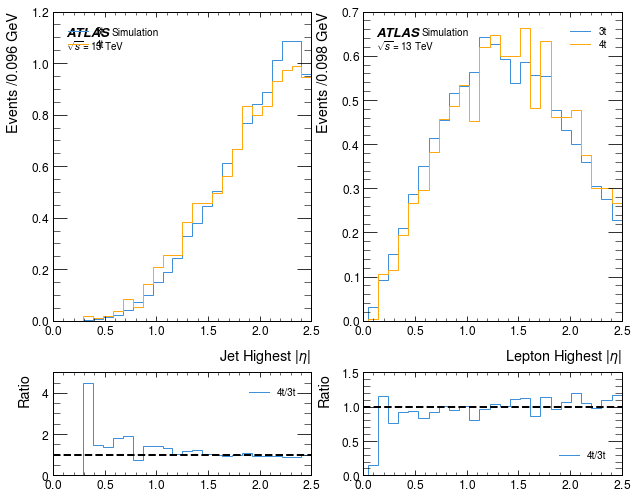

In [12]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(highest_eta_jet_3t.eta), np.abs(highest_eta_jet_4t.eta)], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([np.abs(highest_eta_lepton_3t.eta), np.abs(highest_eta_lepton_4t.eta)], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
ax[0,0].set_xlabel(r'Jet Highest $|\eta|$')
ax[0,1].set_xlabel(r'Lepton Highest $|\eta|$')
plt.subplots_adjust(hspace=0.25)
plt.show()

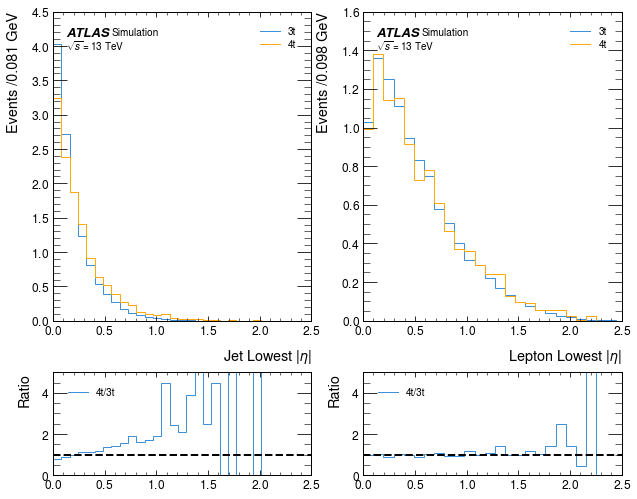

In [13]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([np.abs(lowest_eta_jet_3t.eta), np.abs(lowest_eta_jet_4t.eta)], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([np.abs(lowest_eta_lepton_3t.eta), np.abs(lowest_eta_lepton_4t.eta)], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
ax[0,0].set_xlabel(r'Jet Lowest $|\eta|$')
ax[0,1].set_xlabel(r'Lepton Lowest $|\eta|$')
plt.subplots_adjust(hspace=0.25)
plt.show()

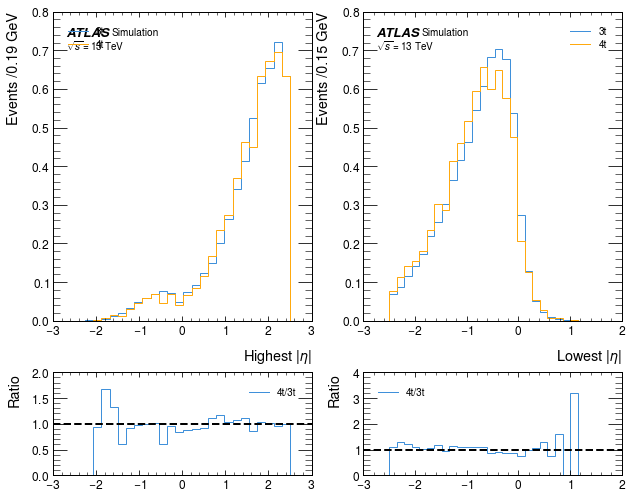

In [14]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_eta_3t.eta, highest_eta_4t.eta], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([lowest_eta_3t.eta, lowest_eta_4t.eta], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
ax[0,0].set_xlabel(r'Highest $|\eta|$')
ax[0,1].set_xlabel(r'Lowest $|\eta|$')
plt.subplots_adjust(hspace=0.25)
plt.show()

### 3. $\phi$

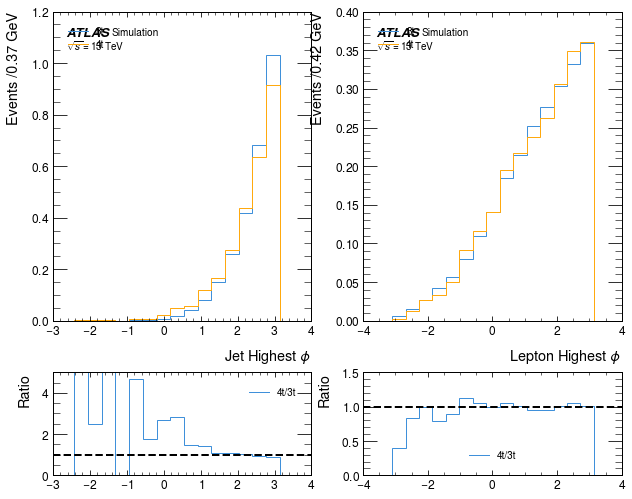

In [15]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_phi_jet_3t.phi, highest_phi_jet_4t.phi], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([highest_phi_lepton_3t.phi, highest_phi_lepton_4t.phi], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
ax[0,0].set_xlabel(r'Jet Highest $\phi$')
ax[0,1].set_xlabel(r'Lepton Highest $\phi$')
plt.subplots_adjust(hspace=0.25)
plt.show()

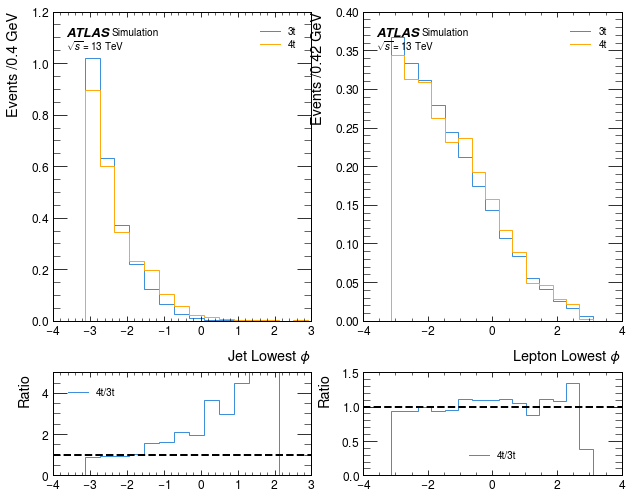

In [16]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_phi_jet_3t.phi, lowest_phi_jet_4t.phi], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([lowest_phi_lepton_3t.phi, lowest_phi_lepton_4t.phi], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
ax[0,0].set_xlabel(r'Jet Lowest $\phi $')
ax[0,1].set_xlabel(r'Lepton Lowest $\phi$')
plt.subplots_adjust(hspace=0.25)
plt.show()

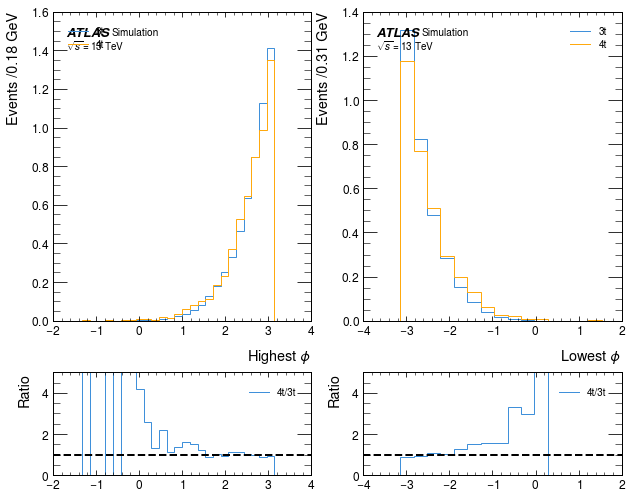

In [17]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_phi_3t.phi, highest_phi_4t.phi], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([lowest_phi_3t.phi, lowest_phi_4t.phi], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
ax[0,0].set_xlabel(r'Highest $\phi$')
ax[0,1].set_xlabel(r'Lowest $\phi$')
plt.subplots_adjust(hspace=0.25)
plt.show()

### 4. $\Delta R$

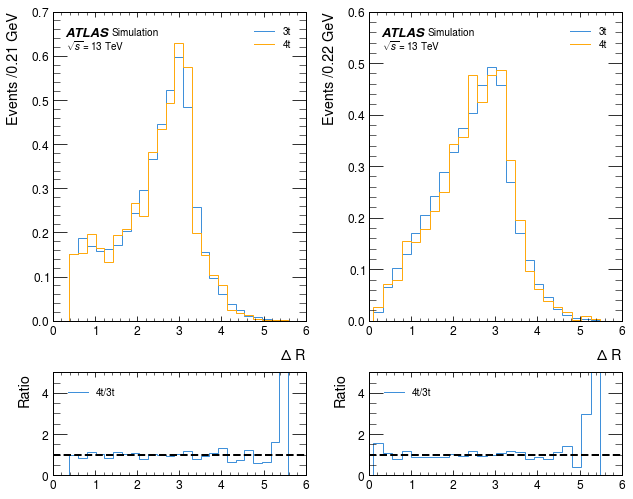

In [18]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_jet_3t.deltaR(second_highest_pt_jet_3t),highest_pt_jet_4t.deltaR(second_highest_pt_jet_4t)], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([highest_pt_lepton_3t.deltaR(second_highest_pt_lepton_3t),highest_pt_lepton_4t.deltaR(second_highest_pt_lepton_4t)], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
ax[0,0].set_xlabel(r'$\Delta$ R')
ax[0,1].set_xlabel(r'$\Delta$ R')
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=0.25)
plt.show()


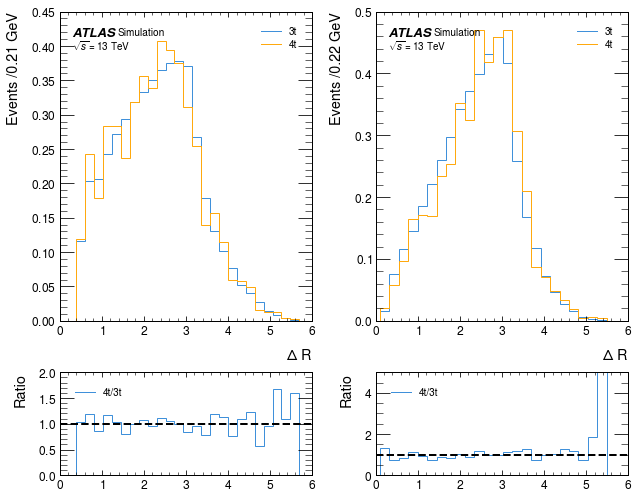

In [19]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_pt_jet_3t.deltaR(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaR(second_lowest_pt_jet_4t)], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([lowest_pt_lepton_3t.deltaR(second_lowest_pt_lepton_3t),lowest_pt_lepton_4t.deltaR(second_lowest_pt_lepton_4t)], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
ax[0,0].set_xlabel(r'$\Delta$ R')
ax[0,1].set_xlabel(r'$\Delta$ R')
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=0.25)
plt.show()


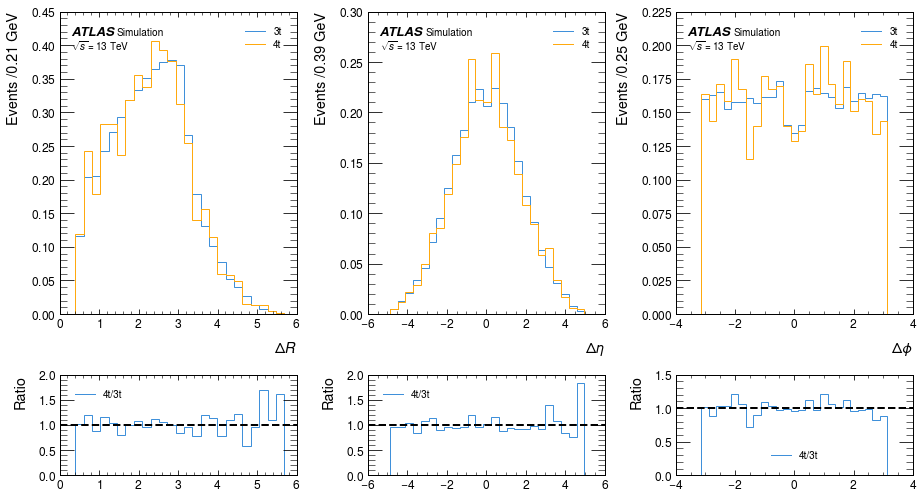

In [20]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([lowest_pt_jet_3t.deltaR(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaR(second_lowest_pt_jet_4t)], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([lowest_pt_jet_3t.deltaeta(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaeta(second_lowest_pt_jet_4t)], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([lowest_pt_jet_3t.deltaphi(second_lowest_pt_jet_3t),lowest_pt_jet_4t.deltaphi(second_lowest_pt_jet_4t)], 25, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
ax[0,2].legend(loc='upper right')
plt.show()

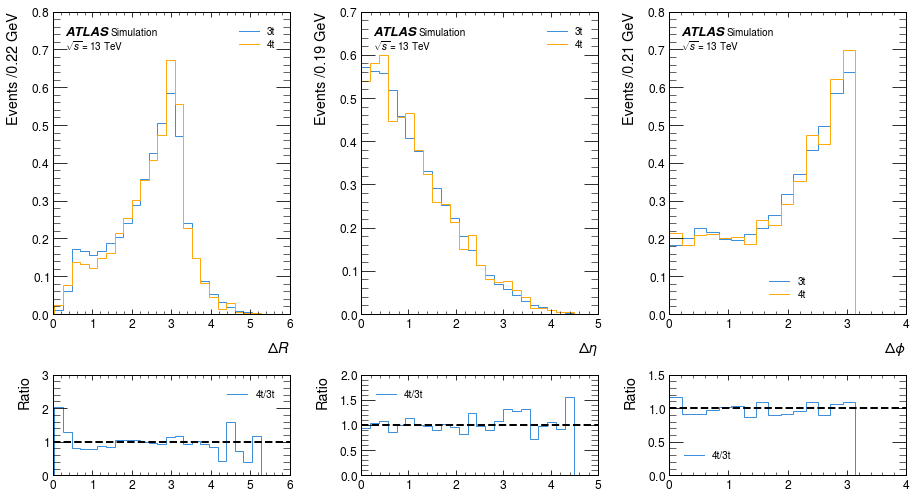

In [21]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_pt_3t, deltaR_highest_pt_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([deltaeta_highest_pt_3t, deltaeta_highest_pt_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([deltaphi_highest_pt_3t, deltaphi_highest_pt_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
ax[0,2].legend(loc='lower center')
plt.show()

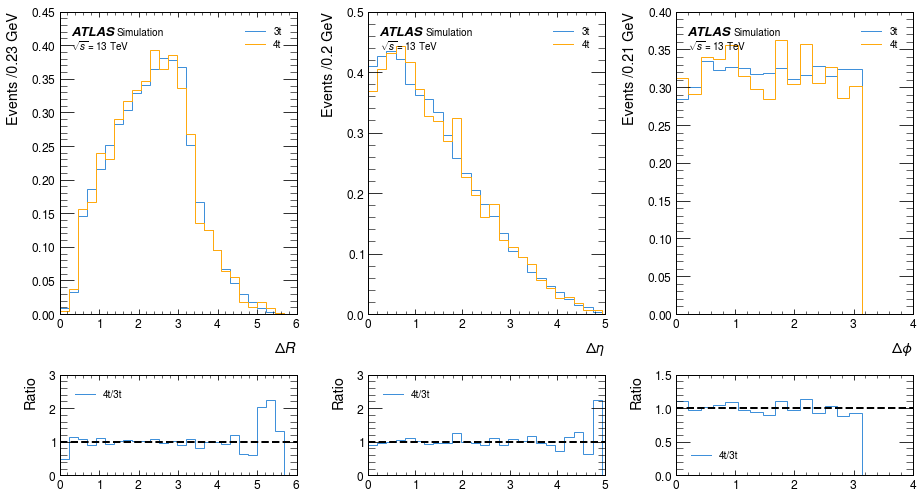

In [22]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_pt_3t, deltaR_lowest_pt_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([deltaeta_lowest_pt_3t, deltaeta_lowest_pt_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([deltaphi_lowest_pt_3t, deltaphi_lowest_pt_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

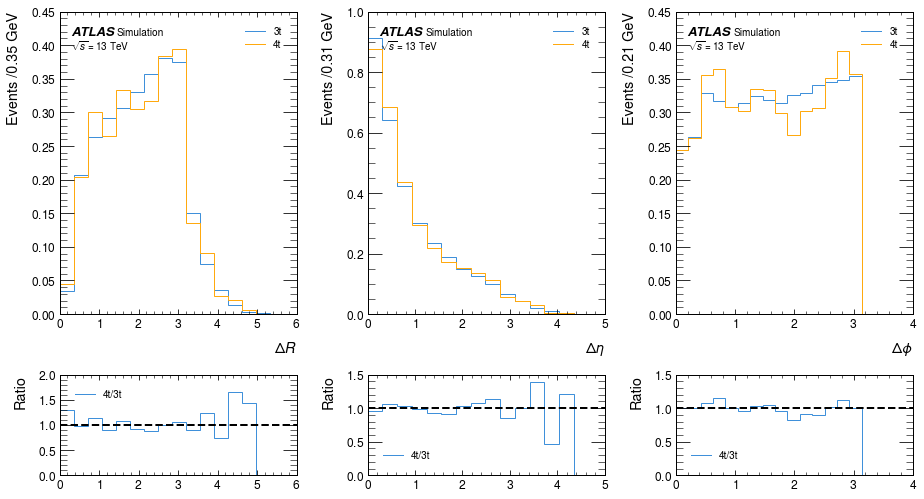

In [23]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_eta_3t, deltaR_highest_eta_4t], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([deltaeta_highest_eta_3t, deltaeta_highest_eta_4t], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([deltaphi_highest_eta_3t, deltaphi_highest_eta_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
ax[0,2].legend(loc='upper right')
plt.show()

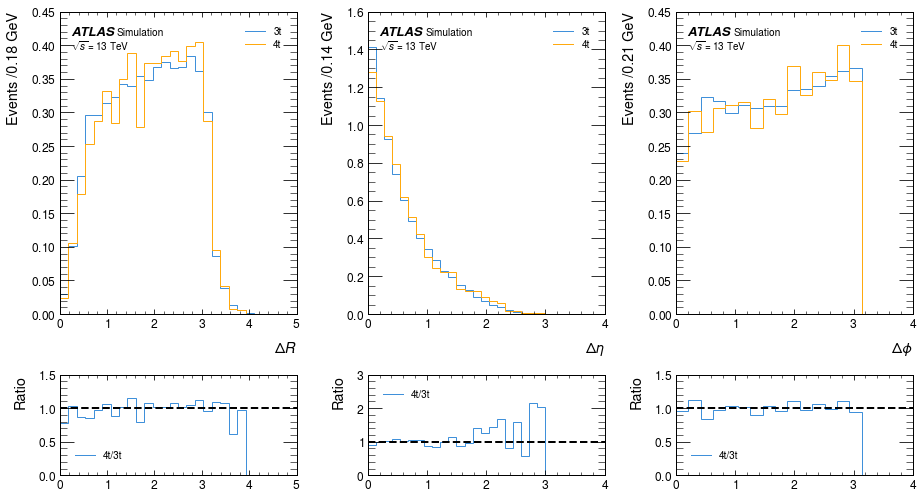

In [24]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_eta_3t, deltaR_lowest_eta_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([deltaeta_lowest_eta_3t, deltaeta_lowest_eta_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([deltaphi_lowest_eta_3t, deltaphi_lowest_eta_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
ax[0,2].legend(loc='upper right')
plt.show()

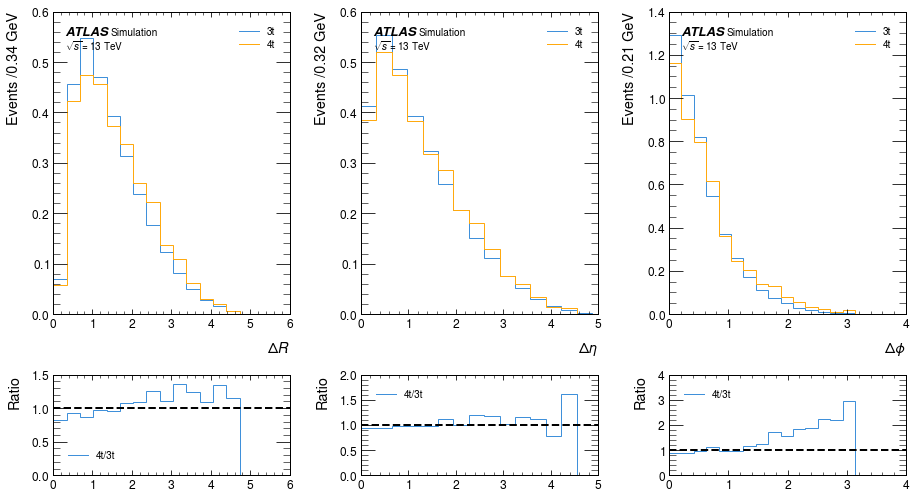

In [25]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_phi_3t, deltaR_highest_phi_4t], 15, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([deltaeta_highest_phi_3t, deltaeta_highest_phi_4t], 15, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([deltaphi_highest_phi_3t, deltaphi_highest_phi_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

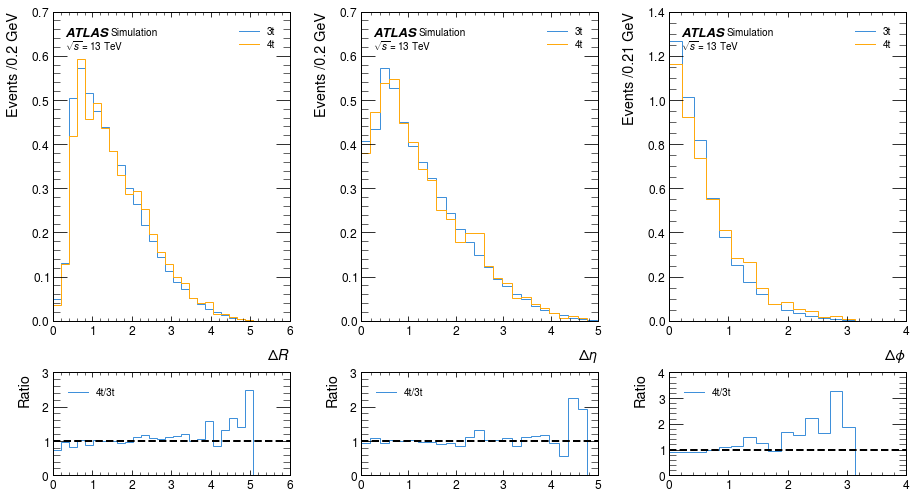

In [26]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_phi_3t, deltaR_lowest_phi_4t], 25, ['3t','4t'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([deltaeta_lowest_phi_3t, deltaeta_lowest_phi_4t], 25, ['3t','4t'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([deltaphi_lowest_phi_3t, deltaphi_lowest_phi_4t], 15, ['3t','4t'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.3)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

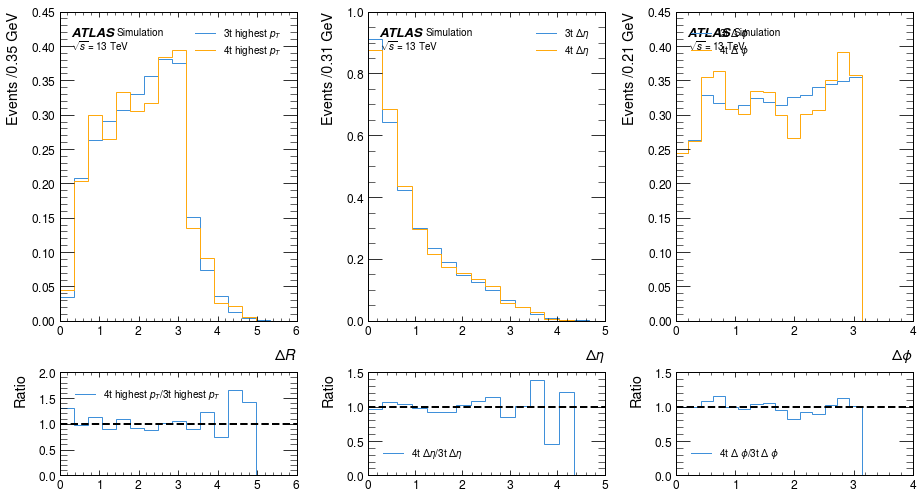

In [27]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_eta_3t, deltaR_highest_eta_4t], 15, ['3t highest $p_T$','4t highest $p_T$'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([deltaeta_highest_eta_3t, deltaeta_highest_eta_4t], 15, ['3t $\Delta \eta$','4t $\Delta \eta$'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([deltaphi_highest_eta_3t, deltaphi_highest_eta_4t], 15, ['3t $\Delta$ $\phi$','4t $\Delta$ $\phi$'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.3)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

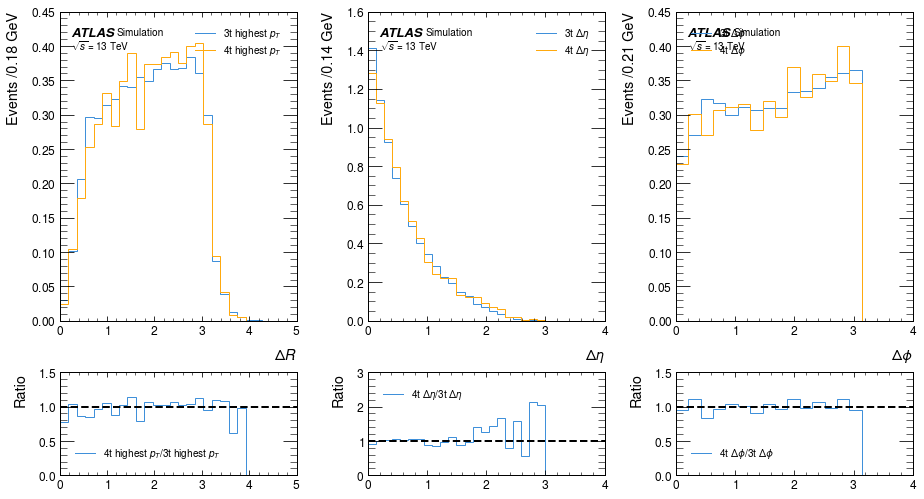

In [28]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_eta_3t, deltaR_lowest_eta_4t], 25, ['3t highest $p_T$','4t highest $p_T$'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([deltaeta_lowest_eta_3t, deltaeta_lowest_eta_4t], 25, ['3t $\Delta\eta$','4t $\Delta \eta$'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([deltaphi_lowest_eta_3t, deltaphi_lowest_eta_4t], 15, ['3t $\Delta\phi$','4t $\Delta\phi$'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.3)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

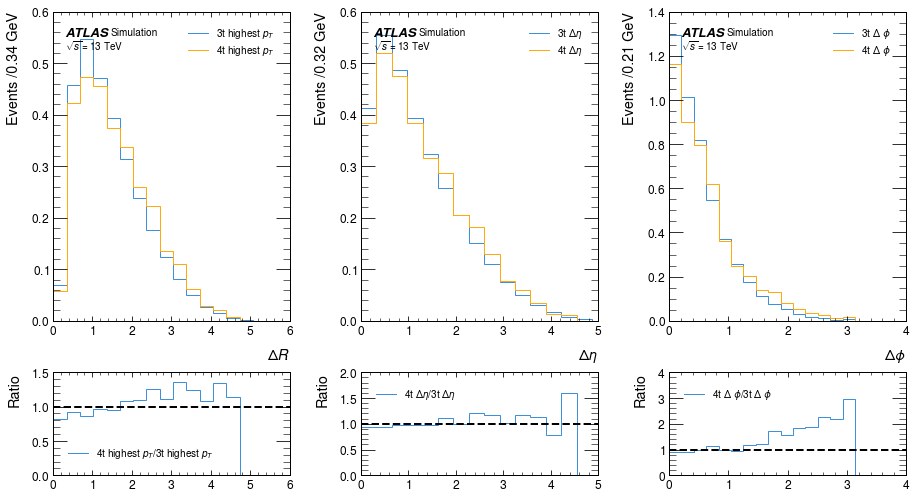

In [29]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_highest_phi_3t, deltaR_highest_phi_4t], 15, ['3t highest $p_T$','4t highest $p_T$'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([deltaeta_highest_phi_3t, deltaeta_highest_phi_4t], 15, ['3t $\Delta \eta$','4t $\Delta \eta$'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([deltaphi_highest_phi_3t, deltaphi_highest_phi_4t], 15, ['3t $\Delta$ $\phi$','4t $\Delta$ $\phi$'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.3)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

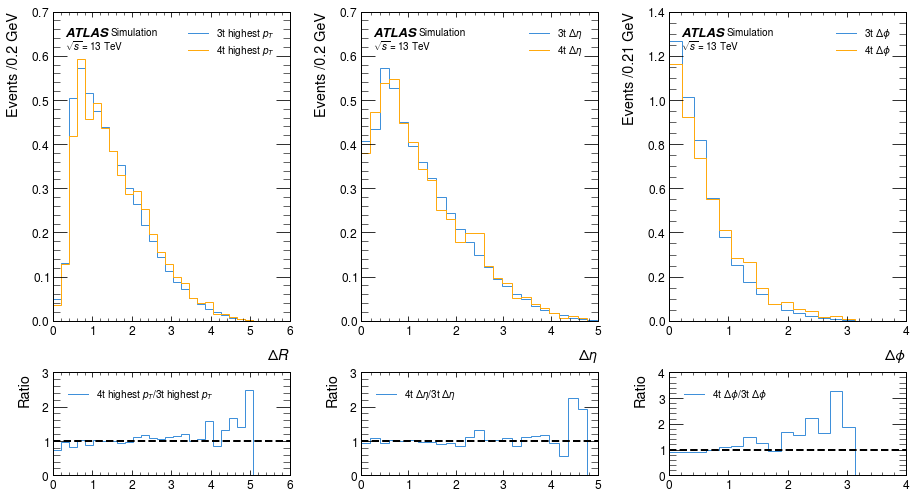

In [30]:
fig, ax = plt.subplots(2,3,gridspec_kw={'height_ratios':[3,1]}, figsize=(15,8))
histogram([deltaR_lowest_phi_3t, deltaR_lowest_phi_4t], 25, ['3t highest $p_T$','4t highest $p_T$'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([deltaeta_lowest_phi_3t, deltaeta_lowest_phi_4t], 25, ['3t $\Delta\eta$','4t $\Delta \eta$'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([deltaphi_lowest_phi_3t, deltaphi_lowest_phi_4t], 15, ['3t $\Delta\phi$','4t $\Delta\phi$'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
ax[0,0].set_xlabel(r'$\Delta R$')
ax[0,1].set_xlabel(r'$\Delta\eta$')
ax[0,2].set_xlabel(r'$\Delta\phi$')
plt.subplots_adjust(hspace=0.25, wspace=0.3)
ax[0,0].legend(loc='upper right')
ax[0,1].legend(loc='upper right')
plt.show()

## Using individual Lepton Channels

### 1. Seperating into 2LSS and 3L

In [31]:
leptons_2LSS_4t = leptons_4t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t,lepton_charges_4t)]).flatten()]
jets_2LSS_4t = jets_4t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_4t,lepton_charges_4t)]).flatten()]

leptons_3L_4t = leptons_4t[np.argwhere([len(a1) >= 3 for a1 in leptons_4t]).flatten()]
jets_3L_4t = jets_4t[np.argwhere([len(a1) >= 3 for a1 in leptons_4t]).flatten()]

ratio_2LSS_4t = len(leptons_2LSS_4t)/(len(leptons_2LSS_4t) + len(leptons_3L_4t))
ratio_3L_4t = len(leptons_3L_4t)/(len(leptons_2LSS_4t) + len(leptons_3L_4t))

leptons_2LSS_3t = leptons_3t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t,lepton_charges_3t)]).flatten()]
jets_2LSS_3t = jets_3t[np.argwhere([len(a1) == 2 and (a2[0] == a2[1]) for a1, a2 in zip(leptons_3t,lepton_charges_3t)]).flatten()]

leptons_3L_3t = leptons_3t[np.argwhere([len(a1) >= 3 for a1 in leptons_3t]).flatten()]
jets_3L_3t = jets_3t[np.argwhere([len(a1) >= 3 for a1 in leptons_3t]).flatten()]

ratio_2LSS_3t = len(leptons_2LSS_3t)/(len(leptons_2LSS_3t) + len(leptons_3L_3t))
ratio_3L_3t = len(leptons_3L_3t)/(len(leptons_2LSS_3t) + len(leptons_3L_3t))

### 2. Sorting

In [32]:
highest_2LSS_pt_jet = jets_2LSS_4t[:,0]
highest_2LSS_pt_lepton = leptons_2LSS_4t[:,0]
highest_2LSS_pt = np.maximum(highest_2LSS_pt_jet.pt, highest_2LSS_pt_lepton.pt)

highest_3L_pt_jet = jets_3L_4t[:,0]
highest_3L_pt_lepton = leptons_3L_4t[:,0]
highest_3L_pt = np.maximum(highest_3L_pt_jet.pt, highest_3L_pt_lepton.pt)

lowest_2LSS_pt_jet = jets_2LSS_4t[:,-1]
lowest_2LSS_pt_lepton = leptons_2LSS_4t[:,-1]
lowest_2LSS_pt = np.minimum(lowest_2LSS_pt_jet.pt, lowest_2LSS_pt_lepton.pt)

lowest_3L_pt_jet = jets_3L_4t[:,-1]
lowest_3L_pt_lepton = leptons_3L_4t[:,-1]
lowest_3L_pt = np.minimum(lowest_3L_pt_jet.pt, lowest_3L_pt_lepton.pt)

second_highest_2LSS_pt_jet = jets_2LSS_4t[:,1]
second_highest_3L_pt_jet = jets_3L_4t[:,1]
middle_3L_pt_lepton = leptons_3L_4t[:,1]

NameError: name 'ratio_2LSS' is not defined

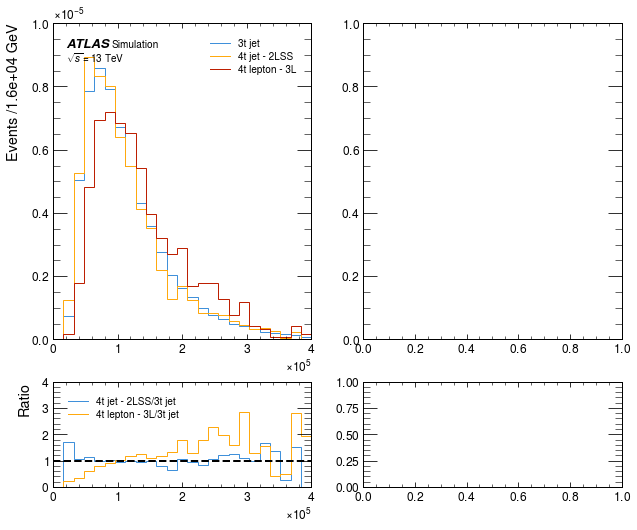

In [33]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_lepton_3t.pt, highest_2LSS_pt_lepton.pt, highest_3L_pt_lepton.pt], 25, ['3t jet','4t jet - 2LSS', '4t lepton - 3L'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,0.4E6))
histogram([highest_pt_jet_3t.pt, highest_2LSS_pt_jet.pt, highest_3L_pt_jet.pt], 25, ['3t jet','4t jet - 2LSS', '4t jet - 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,1E6), weight_array=[1, ratio_2LSS, ratio_3L])

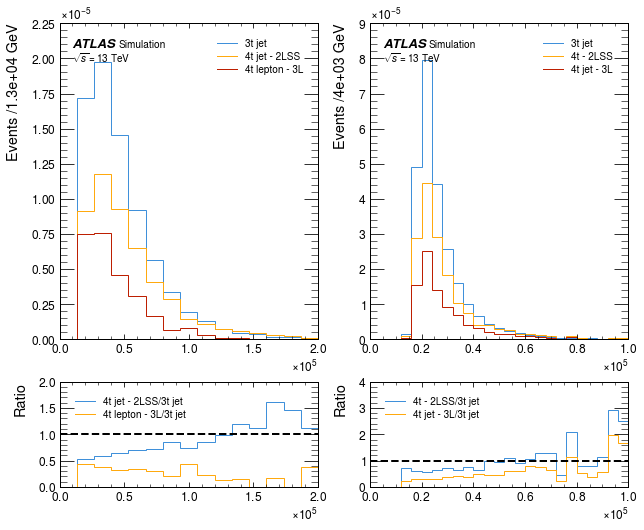

In [27]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([lowest_pt_lepton_3t.pt, lowest_2LSS_pt_lepton.pt, lowest_3L_pt_lepton.pt], 15, ['3t jet','4t jet - 2LSS', '4t lepton - 3L'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,2E5), weight_array=[1, ratio_2LSS, ratio_3L])
histogram([lowest_pt_jet_3t.pt, lowest_2LSS_pt_jet.pt,lowest_3L_pt_jet.pt], 25, ['3t jet','4t - 2LSS','4t jet - 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,1E5), weight_array=[1, ratio_2LSS, ratio_3L])

In [29]:
highest_2LSS_pt_jet_4t = jets_2LSS_4t[:,0]
highest_2LSS_pt_lepton_4t = leptons_2LSS_4t[:,0]
highest_2LSS_pt_4t = np.maximum(highest_2LSS_pt_jet_4t.pt, highest_2LSS_pt_lepton_4t.pt)

highest_3L_pt_jet_4t = jets_3L_4t[:,0]
highest_3L_pt_lepton_4t = leptons_3L_4t[:,0]
highest_3L_pt_4t = np.maximum(highest_3L_pt_jet_4t.pt, highest_3L_pt_lepton_4t.pt)

lowest_2LSS_pt_jet_4t = jets_2LSS_4t[:,-1]
lowest_2LSS_pt_lepton_4t = leptons_2LSS_4t[:,-1]
lowest_2LSS_pt_4t = np.minimum(lowest_2LSS_pt_jet_4t.pt, lowest_2LSS_pt_lepton_4t.pt)

lowest_3L_pt_jet_4t = jets_3L_4t[:,-1]
lowest_3L_pt_lepton_4t = leptons_3L_4t[:,-1]
lowest_3L_pt_4t = np.minimum(lowest_3L_pt_jet_4t.pt, lowest_3L_pt_lepton_4t.pt)

second_highest_2LSS_pt_jet_4t = jets_2LSS_4t[:,1]
second_highest_3L_pt_jet_4t = jets_3L_4t[:,1]
middle_3L_pt_lepton_4t = leptons_3L_4t[:,1]

highest_2LSS_pt_jet_3t = jets_2LSS_3t[:,0]
highest_2LSS_pt_lepton_3t = leptons_2LSS_3t[:,0]
highest_2LSS_pt_3t = np.maximum(highest_2LSS_pt_jet_3t.pt, highest_2LSS_pt_lepton_3t.pt)

highest_3L_pt_jet_3t = jets_3L_3t[:,0]
highest_3L_pt_lepton_3t = leptons_3L_3t[:,0]
highest_3L_pt_3t = np.maximum(highest_3L_pt_jet_3t.pt, highest_3L_pt_lepton_3t.pt)

lowest_2LSS_pt_jet_3t = jets_2LSS_3t[:,-1]
lowest_2LSS_pt_lepton_3t = leptons_2LSS_3t[:,-1]
lowest_2LSS_pt_3t = np.minimum(lowest_2LSS_pt_jet_3t.pt, lowest_2LSS_pt_lepton_3t.pt)

lowest_3L_pt_jet_3t = jets_3L_3t[:,-1]
lowest_3L_pt_lepton_3t = leptons_3L_3t[:,-1]
lowest_3L_pt_3t = np.minimum(lowest_3L_pt_jet_3t.pt, lowest_3L_pt_lepton_3t.pt)

second_highest_2LSS_pt_jet_3t = jets_2LSS_3t[:,1]
second_highest_3L_pt_jet_3t = jets_3L_3t[:,1]
middle_3L_pt_lepton_3t = leptons_3L_3t[:,1]

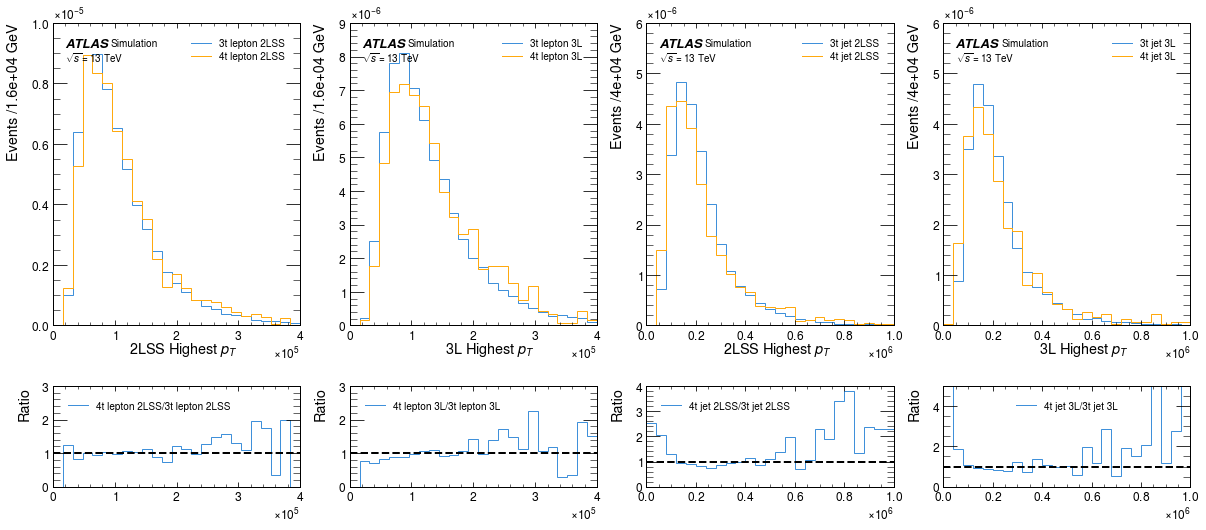

In [45]:
fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([highest_2LSS_pt_lepton_3t.pt, highest_2LSS_pt_lepton_4t.pt], 25, ['3t lepton 2LSS','4t lepton 2LSS'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,0.4E6))
histogram([highest_3L_pt_lepton_3t.pt, highest_3L_pt_lepton_4t.pt], 25, ['3t lepton 3L', '4t lepton 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,0.4E6))
histogram([highest_2LSS_pt_jet_3t.pt, highest_2LSS_pt_jet_4t.pt], 25, ['3t jet 2LSS', '4t jet 2LSS'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, set_range=(0,1E6))
histogram([highest_3L_pt_jet_3t.pt, highest_3L_pt_jet_4t.pt], 25, ['3t jet 3L', '4t jet 3L'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, set_range=(0,1E6))
ax[0,0].set_xlabel(r'2LSS Highest $p_T$')
ax[0,0].xaxis.set_label_coords(0.75, -0.05) 
ax[0,1].set_xlabel(r'3L Highest $p_T$')
ax[0,1].xaxis.set_label_coords(0.75, -0.05) 
ax[0,2].set_xlabel(r'2LSS Highest $p_T$')
ax[0,2].xaxis.set_label_coords(0.75, -0.05) 
ax[0,3].set_xlabel(r'3L Highest $p_T$')
ax[0,3].xaxis.set_label_coords(0.75, -0.05) 
plt.subplots_adjust(hspace=0.3)
plt.show()

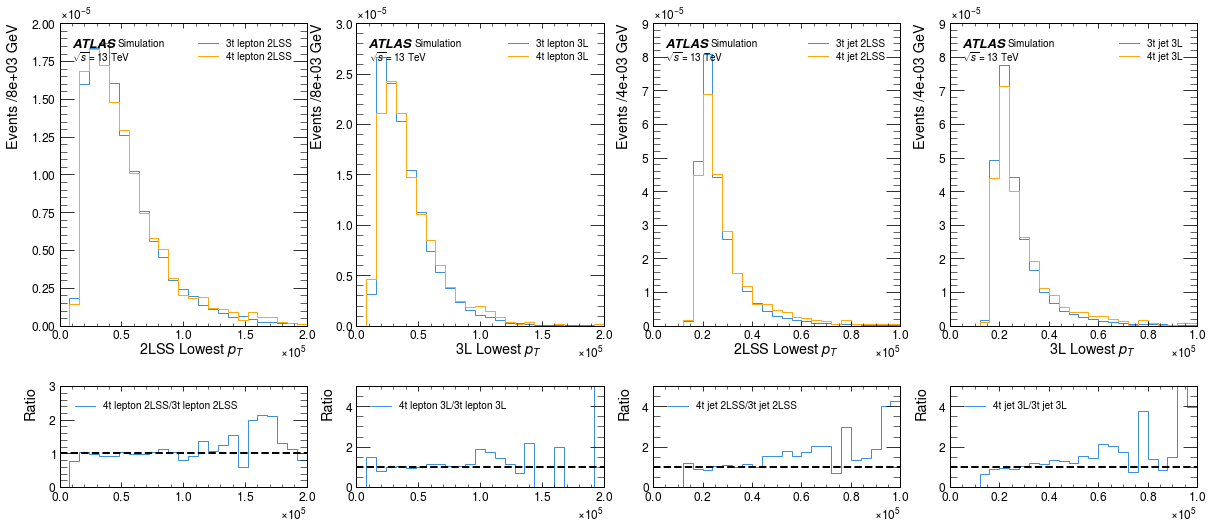

In [48]:
fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([lowest_2LSS_pt_lepton_3t.pt, lowest_2LSS_pt_lepton_4t.pt], 25, ['3t lepton 2LSS','4t lepton 2LSS'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True, set_range=(0,2E5))
histogram([lowest_3L_pt_lepton_3t.pt, lowest_3L_pt_lepton_4t.pt], 25, ['3t lepton 3L', '4t lepton 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True, set_range=(0,2E5))
histogram([lowest_2LSS_pt_jet_3t.pt, lowest_2LSS_pt_jet_4t.pt], 25, ['3t jet 2LSS', '4t jet 2LSS'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True, set_range=(0,1E5))
histogram([lowest_3L_pt_jet_3t.pt, lowest_3L_pt_jet_4t.pt], 25, ['3t jet 3L', '4t jet 3L'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True, set_range=(0,1E5))
ax[0,0].set_xlabel(r'2LSS Lowest $p_T$')
ax[0,0].xaxis.set_label_coords(0.75, -0.05) 
ax[0,1].set_xlabel(r'3L Lowest $p_T$')
ax[0,1].xaxis.set_label_coords(0.75, -0.05) 
ax[0,2].set_xlabel(r'2LSS Lowest $p_T$')
ax[0,2].xaxis.set_label_coords(0.75, -0.05) 
ax[0,3].set_xlabel(r'3L Lowest $p_T$')
ax[0,3].xaxis.set_label_coords(0.75, -0.05) 
plt.subplots_adjust(hspace=0.3)
plt.show()

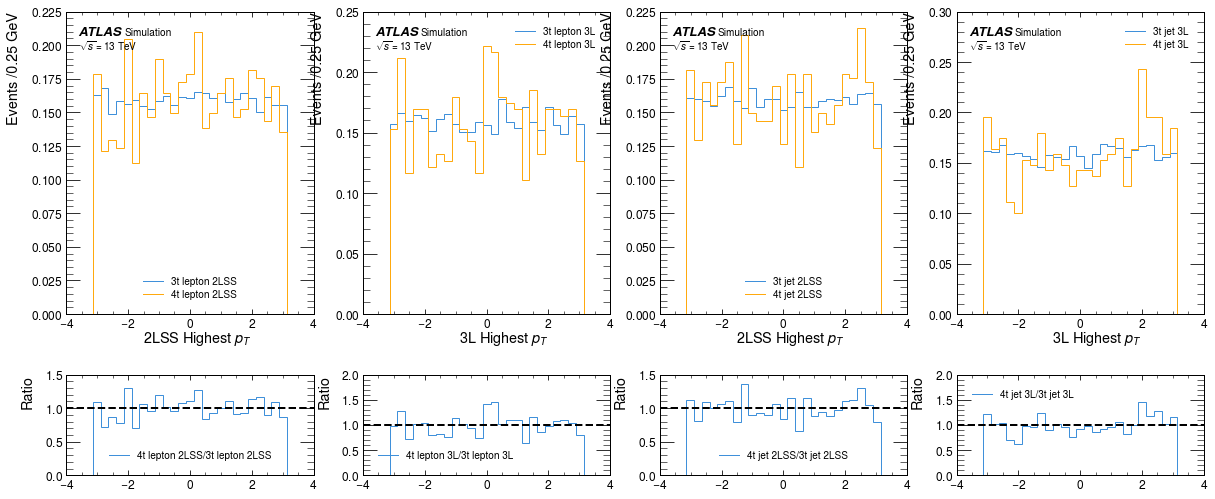

In [59]:
fig, ax = plt.subplots(2,4,gridspec_kw={'height_ratios':[3,1]}, figsize=(20,8))
histogram([highest_2LSS_pt_lepton_3t.phi, highest_2LSS_pt_lepton_4t.phi], 25, ['3t lepton 2LSS','4t lepton 2LSS'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([highest_3L_pt_lepton_3t.phi, highest_3L_pt_lepton_4t.phi], 25, ['3t lepton 3L', '4t lepton 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)
histogram([highest_2LSS_pt_jet_3t.phi, highest_2LSS_pt_jet_4t.phi], 25, ['3t jet 2LSS', '4t jet 2LSS'], ax[0,2], ratio=True, ratio_axes=ax[1,2], density=True)
histogram([highest_3L_pt_jet_3t.phi, highest_3L_pt_jet_4t.phi], 25, ['3t jet 3L', '4t jet 3L'], ax[0,3], ratio=True, ratio_axes=ax[1,3], density=True)
ax[0,0].set_xlabel(r'2LSS Highest $p_T$')
ax[0,0].xaxis.set_label_coords(0.75, -0.05) 
ax[0,1].set_xlabel(r'3L Highest $p_T$')
ax[0,1].xaxis.set_label_coords(0.75, -0.05) 
ax[0,2].set_xlabel(r'2LSS Highest $p_T$')
ax[0,2].xaxis.set_label_coords(0.75, -0.05) 
ax[0,3].set_xlabel(r'3L Highest $p_T$')
ax[0,3].xaxis.set_label_coords(0.75, -0.05) 
plt.subplots_adjust(hspace=0.3)
plt.show()

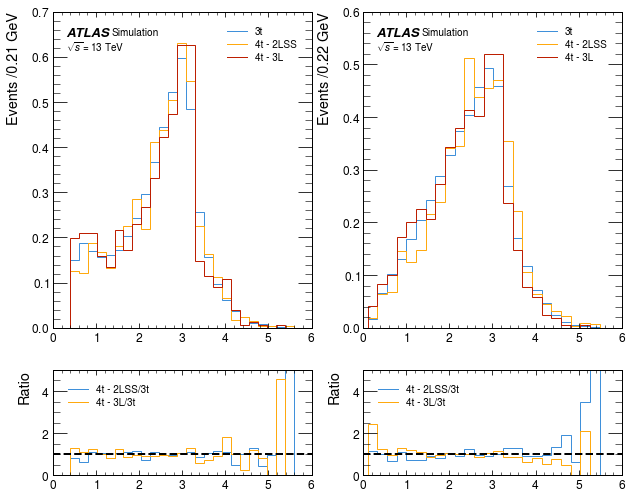

In [197]:
fig, ax = plt.subplots(2,2,gridspec_kw={'height_ratios':[3,1]}, figsize=(10,8))
histogram([highest_pt_jet_3t.deltaR(second_highest_pt_jet_3t), deltaR_2LSS_jets, deltaR_3L_jets], 25, ['3t','4t - 2LSS', '4t - 3L'], ax[0,0], ratio=True, ratio_axes=ax[1,0], density=True)
histogram([highest_pt_lepton_3t.deltaR(second_highest_pt_lepton_3t), deltaR_2LSS_leptons, deltaR_3L_leptons], 25, ['3t','4t - 2LSS', '4t - 3L'], ax[0,1], ratio=True, ratio_axes=ax[1,1], density=True)